# Bayesian Optimization Pythia Tune using Ax

In [1]:
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import importlib

from bayes_opt import BayesianOptimization, UtilityFunction 


from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.utils.measurement.synthetic_functions import hartmann6
from ax.utils.notebook.plotting import init_notebook_plotting, render


# init_notebook_plotting()
# import plotly.io as pio
# pio.renderers.default = "jupyterlab"


#`source /cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc11-opt/setup.sh`
from glob import glob
from tqdm import tqdm
from yoda2numpy_BayesOpt import Yoda2Numpy

from pythia_SBI_utils import *

FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
BAYES_OPT=False
AX=True

In [3]:
def make_pythia_card(aLund, bLund):
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 50000          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")
        f.write(f"StringZ:aLund = {aLund}\n\n")
        f.write(f"StringZ:bLund = {bLund}\n\n")

PARAM_DICT = {
        'StringZ:aLund' : [0.0, 2.0],
        'StringZ:bLund': [0.2, 2.0],
        # 'StringZ:rFactC':[0.0, 1.994052.0],
        # 'StringZ:rFactB': [0., 2.0],
        # 'StringZ:aExtraSQuark':[0.,2],
        # 'StringZ:aExtraDiquark':[0.,2.],
        # 'StringPT:sigma':[0.,1.],
        # 'StringPT:enhancedFraction':[0.,1.],
        # 'StringPT:enhancedWidth':[1.0,4.0],
        # 'StringFlav:ProbStoUD':[0,4.0],
        # 'StringFlav:probQQtoQ':[0,4.0],
        # 'StringFlav:probSQtoQQ':[0,4.0],
        # 'StringFlav:ProbQQ1toQQ0':[0,4.0],
        # 'TimeShower:alphaSvalue':[0.06,0.25],
        # 'TimeShower:pTmin':[0.1,2.0]


}

def get_pbounds(PARAM_DICT):
    pbounds = {}
    for key, value in PARAM_DICT.items():
        p_name = key.split(':')[1]
        p_bound = tuple(value)
        pbounds[p_name] = p_bound
    return pbounds

In [4]:
def true_objective_func(aLund, bLund):
    
    # step 1: write .cmnd file 
    make_pythia_card(aLund, bLund)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd ALEPH_1996_S3486095_card.fifo &
    
    rivet -o ALEPH_1996_S3486095_hist_0.yoda -a ALEPH_1996_S3486095 ALEPH_1996_S3486095_card.fifo

    rm ALEPH_1996_S3486095_card.fifo
    mv ALEPH_1996_S3486095_hist_0.yoda ALEPH_YODAS_BayesOpt/""")
    
    
    dfdata, dfsims, generated_indices = get_data()
    print('DATA DATAFRAME')
    print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
    print('FIRST SIM DATAFRAME')
    print(dfsims[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())
    
    data_keys, mc_keys = get_hist_names(dfdata)

    filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims, data_keys, mc_keys)
    X0 = {}
    for ii, gen_ind in enumerate(generated_indices):
        # X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[gen_ind], which = 0))
        # try:
        #     X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[ii], which = 0))
        try:
            X0[gen_ind] = test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[gen_ind], which = 0)
        except Exception:
            print('test statistic error in file index: ', gen_ind)
            
    if BAYES_OPT:        
        objective_func = - X0[0]
    else:
        objective_func = X0[0]
    os.system("rm ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda")
        
    print(f"objective function = {objective_func}")
    return objective_func

In [5]:
ax_client = AxClient()
ax_client.create_experiment(
name="Ax_Tune_Pythia",
        parameters = [
                    {
                        "name": "aLund",
                        "type": "range",
                        "bounds": [0.2, 1.5],
                    }, 
                    {
                        "name": "bLund",
                        "type": "range",
                        "bounds": [0.2, 1.5],
                    },
                ],
objectives = {"true_objective_func": ObjectiveProperties(minimize=True)},
)

N_ITER = 7
for i in range(N_ITER):
    parameterization, trial_index = ax_client.get_next_trial()
    print(parameterization)
    ax_client.complete_trial(trial_index=trial_index, raw_data=true_objective_func(
        aLund=parameterization["aLund"], bLund=parameterization["bLund"]))



[INFO 05-24 03:06:46] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-24 03:06:46] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter aLund. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-24 03:06:46] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter bLund. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-24 03:06:46] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='aLund', parameter_type=FLOAT, range=[0.2, 1.5]), RangeParameter(name='bLund', parameter_type=FLOAT, range=[0.2, 1.5])], parameter_constraints=[]).
[INFO 0

{'aLund': 0.8425234109163284, 'bLund': 1.0347715020179749}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A             

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-24 03:06:55



 Pythia::next(): 6000 events have been generated 

 Pythia::next(): 7000 events have been generated 


Reading events from 'ALEPH_1996_S3486095_card.fifo'



 Pythia::next(): 8000 events have been generated 


Event 100 (0:00:03 elapsed)
Event 200 (0:00:03 elapsed)
Event 300 (0:00:03 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 400 (0:00:03 elapsed)
Event 500 (0:00:03 elapsed)
Event 600 (0:00:03 elapsed)
Event 700 (0:00:03 elapsed)
Event 800 (0:00:03 elapsed)
Event 900 (0:00:03 elapsed)
Event 1000 (0:00:04 elapsed)
Event 1100 (0:00:04 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 1200 (0:00:04 elapsed)
Event 1300 (0:00:04 elapsed)
Event 1400 (0:00:04 elapsed)
Event 1500 (0:00:04 elapsed)
Event 1600 (0:00:04 elapsed)
Event 1700 (0:00:04 elapsed)
Event 1800 (0:00:04 elapsed)
Event 1900 (0:00:04 elapsed)
Event 2000 (0:00:05 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 2100 (0:00:05 elapsed)
Event 2200 (0:00:05 elapsed)
Event 2300 (0:00:05 elapsed)
Event 2400 (0:00:05 elapsed)
Event 2500 (0:00:05 elapsed)
Event 2600 (0:00:05 elapsed)
Event 2700 (0:00:05 elapsed)
Event 2800 (0:00:05 elapsed)
Event 2900 (0:00:05 elapsed)
Event 3000 (0:00:05 elapsed)
Event 3100 (0:00:06 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 3200 (0:00:06 elapsed)
Event 3300 (0:00:06 elapsed)
Event 3400 (0:00:06 elapsed)
Event 3500 (0:00:06 elapsed)
Event 3600 (0:00:06 elapsed)
Event 3700 (0:00:06 elapsed)
Event 3800 (0:00:06 elapsed)
Event 3900 (0:00:06 elapsed)
Event 4000 (0:00:06 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 4100 (0:00:07 elapsed)
Event 4200 (0:00:07 elapsed)
Event 4300 (0:00:07 elapsed)
Event 4400 (0:00:07 elapsed)
Event 4500 (0:00:07 elapsed)
Event 4600 (0:00:07 elapsed)
Event 4700 (0:00:07 elapsed)
Event 4800 (0:00:07 elapsed)
Event 4900 (0:00:07 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 5000 (0:00:07 elapsed)
Event 5100 (0:00:08 elapsed)
Event 5200 (0:00:08 elapsed)
Event 5300 (0:00:08 elapsed)
Event 5400 (0:00:08 elapsed)
Event 5500 (0:00:08 elapsed)
Event 5600 (0:00:08 elapsed)
Event 5700 (0:00:08 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 5800 (0:00:08 elapsed)
Event 5900 (0:00:08 elapsed)
Event 6000 (0:00:08 elapsed)
Event 6100 (0:00:08 elapsed)
Event 6200 (0:00:09 elapsed)
Event 6300 (0:00:09 elapsed)
Event 6400 (0:00:09 elapsed)
Event 6500 (0:00:09 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 6600 (0:00:09 elapsed)
Event 6700 (0:00:09 elapsed)
Event 6800 (0:00:09 elapsed)
Event 6900 (0:00:09 elapsed)
Event 7000 (0:00:09 elapsed)
Event 7100 (0:00:09 elapsed)
Event 7200 (0:00:10 elapsed)
Event 7300 (0:00:10 elapsed)
Event 7400 (0:00:10 elapsed)
Event 7500 (0:00:10 elapsed)
Event 7600 (0:00:10 elapsed)
Event 7700 (0:00:10 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 7800 (0:00:10 elapsed)
Event 7900 (0:00:10 elapsed)
Event 8000 (0:00:10 elapsed)
Event 8100 (0:00:10 elapsed)
Event 8200 (0:00:10 elapsed)
Event 8300 (0:00:11 elapsed)
Event 8400 (0:00:11 elapsed)
Event 8500 (0:00:11 elapsed)
Event 8600 (0:00:11 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 8700 (0:00:11 elapsed)
Event 8800 (0:00:11 elapsed)
Event 8900 (0:00:11 elapsed)
Event 9000 (0:00:11 elapsed)
Event 9100 (0:00:11 elapsed)
Event 9200 (0:00:11 elapsed)
Event 9300 (0:00:12 elapsed)
Event 9400 (0:00:12 elapsed)
Event 9500 (0:00:12 elapsed)
Event 9600 (0:00:12 elapsed)
Event 9700 (0:00:12 elapsed)
Event 9800 (0:00:12 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 9900 (0:00:12 elapsed)
Event 10000 (0:00:12 elapsed)
Event 10100 (0:00:12 elapsed)
Event 10200 (0:00:12 elapsed)
Event 10300 (0:00:12 elapsed)
Event 10400 (0:00:13 elapsed)
Event 10500 (0:00:13 elapsed)
Event 10600 (0:00:13 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 10700 (0:00:13 elapsed)
Event 10800 (0:00:13 elapsed)
Event 10900 (0:00:13 elapsed)
Event 11000 (0:00:13 elapsed)
Event 11100 (0:00:13 elapsed)
Event 11200 (0:00:13 elapsed)
Event 11300 (0:00:13 elapsed)
Event 11400 (0:00:14 elapsed)
Event 11500 (0:00:14 elapsed)
Event 11600 (0:00:14 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 11700 (0:00:14 elapsed)
Event 11800 (0:00:14 elapsed)
Event 11900 (0:00:14 elapsed)
Event 12000 (0:00:14 elapsed)
Event 12100 (0:00:14 elapsed)
Event 12200 (0:00:14 elapsed)
Event 12300 (0:00:14 elapsed)
Event 12400 (0:00:15 elapsed)
Event 12500 (0:00:15 elapsed)
Event 12600 (0:00:15 elapsed)
Event 12700 (0:00:15 elapsed)
Event 12800 (0:00:15 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 12900 (0:00:15 elapsed)
Event 13000 (0:00:15 elapsed)
Event 13100 (0:00:15 elapsed)
Event 13200 (0:00:15 elapsed)
Event 13300 (0:00:15 elapsed)
Event 13400 (0:00:16 elapsed)
Event 13500 (0:00:16 elapsed)
Event 13600 (0:00:16 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 13700 (0:00:16 elapsed)
Event 13800 (0:00:16 elapsed)
Event 13900 (0:00:16 elapsed)
Event 14000 (0:00:16 elapsed)
Event 14100 (0:00:16 elapsed)
Event 14200 (0:00:16 elapsed)
Event 14300 (0:00:16 elapsed)
Event 14400 (0:00:16 elapsed)
Event 14500 (0:00:17 elapsed)
Event 14600 (0:00:17 elapsed)
Event 14700 (0:00:17 elapsed)
Event 14800 (0:00:17 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 14900 (0:00:17 elapsed)
Event 15000 (0:00:17 elapsed)
Event 15100 (0:00:17 elapsed)
Event 15200 (0:00:17 elapsed)
Event 15300 (0:00:17 elapsed)
Event 15400 (0:00:17 elapsed)
Event 15500 (0:00:18 elapsed)
Event 15600 (0:00:18 elapsed)
Event 15700 (0:00:18 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 15800 (0:00:18 elapsed)
Event 15900 (0:00:18 elapsed)
Event 16000 (0:00:18 elapsed)
Event 16100 (0:00:18 elapsed)
Event 16200 (0:00:18 elapsed)
Event 16300 (0:00:18 elapsed)
Event 16400 (0:00:18 elapsed)
Event 16500 (0:00:19 elapsed)
Event 16600 (0:00:19 elapsed)
Event 16700 (0:00:19 elapsed)
Event 16800 (0:00:19 elapsed)
Event 16900 (0:00:19 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 17000 (0:00:19 elapsed)
Event 17100 (0:00:19 elapsed)
Event 17200 (0:00:19 elapsed)
Event 17300 (0:00:19 elapsed)
Event 17400 (0:00:19 elapsed)
Event 17500 (0:00:19 elapsed)
Event 17600 (0:00:20 elapsed)
Event 17700 (0:00:20 elapsed)
Event 17800 (0:00:20 elapsed)
Event 17900 (0:00:20 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 18000 (0:00:20 elapsed)
Event 18100 (0:00:20 elapsed)
Event 18200 (0:00:20 elapsed)
Event 18300 (0:00:20 elapsed)
Event 18400 (0:00:20 elapsed)
Event 18500 (0:00:20 elapsed)
Event 18600 (0:00:21 elapsed)
Event 18700 (0:00:21 elapsed)
Event 18800 (0:00:21 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 18900 (0:00:21 elapsed)
Event 19000 (0:00:21 elapsed)
Event 19100 (0:00:21 elapsed)
Event 19200 (0:00:21 elapsed)
Event 19300 (0:00:21 elapsed)
Event 19400 (0:00:21 elapsed)
Event 19500 (0:00:21 elapsed)
Event 19600 (0:00:21 elapsed)
Event 19700 (0:00:22 elapsed)
Event 19800 (0:00:22 elapsed)
Event 19900 (0:00:22 elapsed)
Event 20000 (0:00:22 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 20100 (0:00:22 elapsed)
Event 20200 (0:00:22 elapsed)
Event 20300 (0:00:22 elapsed)
Event 20400 (0:00:22 elapsed)
Event 20500 (0:00:22 elapsed)
Event 20600 (0:00:22 elapsed)
Event 20700 (0:00:23 elapsed)
Event 20800 (0:00:23 elapsed)
Event 20900 (0:00:23 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 21000 (0:00:23 elapsed)
Event 21100 (0:00:23 elapsed)
Event 21200 (0:00:23 elapsed)
Event 21300 (0:00:23 elapsed)
Event 21400 (0:00:23 elapsed)
Event 21500 (0:00:23 elapsed)
Event 21600 (0:00:23 elapsed)
Event 21700 (0:00:23 elapsed)
Event 21800 (0:00:24 elapsed)
Event 21900 (0:00:24 elapsed)
Event 22000 (0:00:24 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 22100 (0:00:24 elapsed)
Event 22200 (0:00:24 elapsed)
Event 22300 (0:00:24 elapsed)
Event 22400 (0:00:24 elapsed)
Event 22500 (0:00:24 elapsed)
Event 22600 (0:00:24 elapsed)
Event 22700 (0:00:24 elapsed)
Event 22800 (0:00:24 elapsed)
Event 22900 (0:00:25 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 23000 (0:00:25 elapsed)
Event 23100 (0:00:25 elapsed)
Event 23200 (0:00:25 elapsed)
Event 23300 (0:00:25 elapsed)
Event 23400 (0:00:25 elapsed)
Event 23500 (0:00:25 elapsed)
Event 23600 (0:00:25 elapsed)
Event 23700 (0:00:25 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 23800 (0:00:25 elapsed)
Event 23900 (0:00:25 elapsed)
Event 24000 (0:00:26 elapsed)
Event 24100 (0:00:26 elapsed)
Event 24200 (0:00:26 elapsed)
Event 24300 (0:00:26 elapsed)
Event 24400 (0:00:26 elapsed)
Event 24500 (0:00:26 elapsed)
Event 24600 (0:00:26 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 24700 (0:00:26 elapsed)
Event 24800 (0:00:26 elapsed)
Event 24900 (0:00:26 elapsed)
Event 25000 (0:00:27 elapsed)
Event 25100 (0:00:27 elapsed)
Event 25200 (0:00:27 elapsed)
Event 25300 (0:00:27 elapsed)
Event 25400 (0:00:27 elapsed)
Event 25500 (0:00:27 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 25600 (0:00:27 elapsed)
Event 25700 (0:00:28 elapsed)
Event 25800 (0:00:28 elapsed)
Event 25900 (0:00:28 elapsed)
Event 26000 (0:00:28 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 26100 (0:00:28 elapsed)
Event 26200 (0:00:28 elapsed)
Event 26300 (0:00:28 elapsed)
Event 26400 (0:00:28 elapsed)
Event 26500 (0:00:29 elapsed)
Event 26600 (0:00:29 elapsed)
Event 26700 (0:00:29 elapsed)
Event 26800 (0:00:29 elapsed)
Event 26900 (0:00:29 elapsed)
Event 27000 (0:00:29 elapsed)
Event 27100 (0:00:29 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 27200 (0:00:29 elapsed)
Event 27300 (0:00:29 elapsed)
Event 27400 (0:00:29 elapsed)
Event 27500 (0:00:30 elapsed)
Event 27600 (0:00:30 elapsed)
Event 27700 (0:00:30 elapsed)
Event 27800 (0:00:30 elapsed)
Event 27900 (0:00:30 elapsed)
Event 28000 (0:00:30 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 28100 (0:00:30 elapsed)
Event 28200 (0:00:30 elapsed)
Event 28300 (0:00:30 elapsed)
Event 28400 (0:00:30 elapsed)
Event 28500 (0:00:31 elapsed)
Event 28600 (0:00:31 elapsed)
Event 28700 (0:00:31 elapsed)
Event 28800 (0:00:31 elapsed)
Event 28900 (0:00:31 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 29000 (0:00:31 elapsed)
Event 29100 (0:00:31 elapsed)
Event 29200 (0:00:31 elapsed)
Event 29300 (0:00:31 elapsed)
Event 29400 (0:00:31 elapsed)
Event 29500 (0:00:31 elapsed)
Event 29600 (0:00:32 elapsed)
Event 29700 (0:00:32 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 29800 (0:00:32 elapsed)
Event 29900 (0:00:32 elapsed)
Event 30000 (0:00:32 elapsed)
Event 30100 (0:00:32 elapsed)
Event 30200 (0:00:32 elapsed)
Event 30300 (0:00:32 elapsed)
Event 30400 (0:00:33 elapsed)
Event 30500 (0:00:33 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 30600 (0:00:33 elapsed)
Event 30700 (0:00:33 elapsed)
Event 30800 (0:00:33 elapsed)
Event 30900 (0:00:33 elapsed)
Event 31000 (0:00:33 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 31100 (0:00:34 elapsed)
Event 31200 (0:00:34 elapsed)
Event 31300 (0:00:34 elapsed)
Event 31400 (0:00:34 elapsed)
Event 31500 (0:00:34 elapsed)
Event 31600 (0:00:35 elapsed)
Event 31700 (0:00:35 elapsed)
Event 31800 (0:00:35 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 31900 (0:00:35 elapsed)
Event 32000 (0:00:35 elapsed)
Event 32100 (0:00:35 elapsed)
Event 32200 (0:00:35 elapsed)
Event 32300 (0:00:36 elapsed)
Event 32400 (0:00:36 elapsed)
Event 32500 (0:00:36 elapsed)
Event 32600 (0:00:36 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 32700 (0:00:36 elapsed)
Event 32800 (0:00:36 elapsed)
Event 32900 (0:00:36 elapsed)
Event 33000 (0:00:36 elapsed)
Event 33100 (0:00:36 elapsed)
Event 33200 (0:00:36 elapsed)
Event 33300 (0:00:36 elapsed)
Event 33400 (0:00:37 elapsed)
Event 33500 (0:00:37 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 33600 (0:00:37 elapsed)
Event 33700 (0:00:37 elapsed)
Event 33800 (0:00:37 elapsed)
Event 33900 (0:00:37 elapsed)
Event 34000 (0:00:37 elapsed)
Event 34100 (0:00:37 elapsed)
Event 34200 (0:00:37 elapsed)
Event 34300 (0:00:37 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 34400 (0:00:38 elapsed)
Event 34500 (0:00:38 elapsed)
Event 34600 (0:00:38 elapsed)
Event 34700 (0:00:38 elapsed)
Event 34800 (0:00:38 elapsed)
Event 34900 (0:00:38 elapsed)
Event 35000 (0:00:38 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 35100 (0:00:38 elapsed)
Event 35200 (0:00:38 elapsed)
Event 35300 (0:00:39 elapsed)
Event 35400 (0:00:39 elapsed)
Event 35500 (0:00:39 elapsed)
Event 35600 (0:00:39 elapsed)
Event 35700 (0:00:39 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 35800 (0:00:39 elapsed)
Event 35900 (0:00:39 elapsed)
Event 36000 (0:00:39 elapsed)
Event 36100 (0:00:39 elapsed)
Event 36200 (0:00:40 elapsed)
Event 36300 (0:00:40 elapsed)
Event 36400 (0:00:40 elapsed)
Event 36500 (0:00:40 elapsed)
Event 36600 (0:00:40 elapsed)
Event 36700 (0:00:40 elapsed)
Event 36800 (0:00:40 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 36900 (0:00:40 elapsed)
Event 37000 (0:00:40 elapsed)
Event 37100 (0:00:41 elapsed)
Event 37200 (0:00:41 elapsed)
Event 37300 (0:00:41 elapsed)
Event 37400 (0:00:41 elapsed)
Event 37500 (0:00:41 elapsed)
Event 37600 (0:00:41 elapsed)
Event 37700 (0:00:41 elapsed)
Event 37800 (0:00:41 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |       52485      50000      50000 |   4.144e-05  0.000e+00 |
 |                                                    |        

Event 37900 (0:00:41 elapsed)
Event 38000 (0:00:42 elapsed)
Event 38100 (0:00:42 elapsed)
Event 38200 (0:00:42 elapsed)
Event 38300 (0:00:42 elapsed)
Event 38400 (0:00:42 elapsed)
Event 38500 (0:00:42 elapsed)
Event 38600 (0:00:42 elapsed)
Event 38700 (0:00:42 elapsed)
Event 38800 (0:00:42 elapsed)
Event 38900 (0:00:42 elapsed)
Event 39000 (0:00:43 elapsed)
Event 39100 (0:00:43 elapsed)
Event 39200 (0:00:43 elapsed)
Event 39300 (0:00:43 elapsed)
Event 39400 (0:00:43 elapsed)
Event 39500 (0:00:43 elapsed)
Event 39600 (0:00:43 elapsed)
Event 39700 (0:00:43 elapsed)
Event 39800 (0:00:43 elapsed)
Event 39900 (0:00:43 elapsed)
Event 40000 (0:00:44 elapsed)
Event 40100 (0:00:44 elapsed)
Event 40200 (0:00:44 elapsed)
Event 40300 (0:00:44 elapsed)
Event 40400 (0:00:44 elapsed)
Event 40500 (0:00:44 elapsed)
Event 40600 (0:00:44 elapsed)
Event 40700 (0:00:44 elapsed)
Event 40800 (0:00:45 elapsed)
Event 40900 (0:00:45 elapsed)
Event 41000 (0:00:45 elapsed)
Event 41100 (0:00:45 elapsed)
Event 4120





Rivet.AnalysisHandler: INFO  Using named weights
[0]
looping over 1 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.40it/s]

using filename ALEPH_YODAS_BayesOpt//ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt//data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME



[INFO 05-24 03:07:49] ax.service.ax_client: Completed trial 0 with data: {'true_objective_func': (2.465942, None)}.


    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.984000  0.043936  0.037891  0.028619      2746.0
1  0.005  0.010  23.504000  0.094016  0.176560  0.274770      5876.0
2  0.010  0.015  21.327999  0.085312  0.265249  0.668513      5332.0
3  0.015  0.020  17.236000  0.068944  0.300780  1.057024      4309.0
4  0.020  0.025  13.468000  0.053872  0.301824  1.358407      3367.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEP

[INFO 05-24 03:07:49] ax.service.ax_client: Generated new trial 1 with parameters {'aLund': 0.330866, 'bLund': 0.922598} using model Sobol.


{'aLund': 0.33086564326658846, 'bLund': 0.9225978581234813}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A            

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-24 03:07:51
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2600 (0:00:03 elapsed)
Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:04 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3400 (0:00:04 elapsed)
Event 3500 (0:00:04 elapsed)
Event 3600 (0:00:04 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4100 (0:00:04 elapsed)
Event 4200 (0:00:05 elapsed)
Event 4300 (0:00:05 elapsed)
Event 4400 (0:00:05 elapsed)
Event 4500 (0:00:05 elapsed)
Event 4600 (0:00:05 elapsed)
Event 4700 (0:00:05 elapsed)
Event 4800 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 4900 (0:00:05 elapsed)
Event 5000 (0:00:05 elapsed)
Event 5100 (0:00:06 elapsed)
Event 5200 (0:00:06 elapsed)
Event 5300 (0:00:06 elapsed)
Event 5400 (0:00:06 elapsed)
Event 5500 (0:00:06 elapsed)
Event 5600 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 5700 (0:00:06 elapsed)
Event 5800 (0:00:06 elapsed)
Event 5900 (0:00:06 elapsed)
Event 6000 (0:00:07 elapsed)
Event 6100 (0:00:07 elapsed)
Event 6200 (0:00:07 elapsed)
Event 6300 (0:00:07 elapsed)
Event 6400 (0:00:07 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6500 (0:00:07 elapsed)
Event 6600 (0:00:07 elapsed)
Event 6700 (0:00:07 elapsed)
Event 6800 (0:00:08 elapsed)
Event 6900 (0:00:08 elapsed)
Event 7000 (0:00:08 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7100 (0:00:08 elapsed)
Event 7200 (0:00:08 elapsed)
Event 7300 (0:00:08 elapsed)
Event 7400 (0:00:08 elapsed)
Event 7500 (0:00:08 elapsed)
Event 7600 (0:00:09 elapsed)
Event 7700 (0:00:09 elapsed)
Event 7800 (0:00:09 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 7900 (0:00:09 elapsed)
Event 8000 (0:00:09 elapsed)
Event 8100 (0:00:09 elapsed)
Event 8200 (0:00:09 elapsed)
Event 8300 (0:00:10 elapsed)
Event 8400 (0:00:10 elapsed)
Event 8500 (0:00:10 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 8600 (0:00:10 elapsed)
Event 8700 (0:00:10 elapsed)
Event 8800 (0:00:10 elapsed)
Event 8900 (0:00:10 elapsed)
Event 9000 (0:00:10 elapsed)
Event 9100 (0:00:10 elapsed)
Event 9200 (0:00:10 elapsed)
Event 9300 (0:00:11 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 9400 (0:00:11 elapsed)
Event 9500 (0:00:11 elapsed)
Event 9600 (0:00:11 elapsed)
Event 9700 (0:00:11 elapsed)
Event 9800 (0:00:11 elapsed)
Event 9900 (0:00:11 elapsed)
Event 10000 (0:00:11 elapsed)
Event 10100 (0:00:11 elapsed)
Event 10200 (0:00:11 elapsed)
Event 10300 (0:00:12 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 10400 (0:00:12 elapsed)
Event 10500 (0:00:12 elapsed)
Event 10600 (0:00:12 elapsed)
Event 10700 (0:00:12 elapsed)
Event 10800 (0:00:12 elapsed)
Event 10900 (0:00:12 elapsed)
Event 11000 (0:00:12 elapsed)
Event 11100 (0:00:12 elapsed)
Event 11200 (0:00:12 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 11300 (0:00:13 elapsed)
Event 11400 (0:00:13 elapsed)
Event 11500 (0:00:13 elapsed)
Event 11600 (0:00:13 elapsed)
Event 11700 (0:00:13 elapsed)
Event 11800 (0:00:13 elapsed)
Event 11900 (0:00:13 elapsed)
Event 12000 (0:00:13 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 12100 (0:00:13 elapsed)
Event 12200 (0:00:13 elapsed)
Event 12300 (0:00:14 elapsed)
Event 12400 (0:00:14 elapsed)
Event 12500 (0:00:14 elapsed)
Event 12600 (0:00:14 elapsed)
Event 12700 (0:00:14 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 12800 (0:00:14 elapsed)
Event 12900 (0:00:14 elapsed)
Event 13000 (0:00:14 elapsed)
Event 13100 (0:00:14 elapsed)
Event 13200 (0:00:15 elapsed)
Event 13300 (0:00:15 elapsed)
Event 13400 (0:00:15 elapsed)
Event 13500 (0:00:15 elapsed)
Event 13600 (0:00:15 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 13700 (0:00:15 elapsed)
Event 13800 (0:00:15 elapsed)
Event 13900 (0:00:15 elapsed)
Event 14000 (0:00:15 elapsed)
Event 14100 (0:00:15 elapsed)
Event 14200 (0:00:16 elapsed)
Event 14300 (0:00:16 elapsed)
Event 14400 (0:00:16 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 14500 (0:00:16 elapsed)
Event 14600 (0:00:16 elapsed)
Event 14700 (0:00:16 elapsed)
Event 14800 (0:00:16 elapsed)
Event 14900 (0:00:16 elapsed)
Event 15000 (0:00:16 elapsed)
Event 15100 (0:00:16 elapsed)
Event 15200 (0:00:16 elapsed)
Event 15300 (0:00:17 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 15400 (0:00:17 elapsed)
Event 15500 (0:00:17 elapsed)
Event 15600 (0:00:17 elapsed)
Event 15700 (0:00:17 elapsed)
Event 15800 (0:00:17 elapsed)
Event 15900 (0:00:17 elapsed)
Event 16000 (0:00:17 elapsed)
Event 16100 (0:00:17 elapsed)
Event 16200 (0:00:17 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 16300 (0:00:18 elapsed)
Event 16400 (0:00:18 elapsed)
Event 16500 (0:00:18 elapsed)
Event 16600 (0:00:18 elapsed)
Event 16700 (0:00:18 elapsed)
Event 16800 (0:00:18 elapsed)


 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  

 Pythia::next(): 23000 events have been generated 


Event 16900 (0:00:18 elapsed)
Event 17000 (0:00:18 elapsed)
Event 17100 (0:00:18 elapsed)
Event 17200 (0:00:18 elapsed)
Event 17300 (0:00:19 elapsed)
Event 17400 (0:00:19 elapsed)
Event 17500 (0:00:19 elapsed)
Event 17600 (0:00:19 elapsed)
Event 17700 (0:00:19 elapsed)
Event 17800 (0:00:19 elapsed)
Event 17900 (0:00:19 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 18000 (0:00:19 elapsed)
Event 18100 (0:00:19 elapsed)
Event 18200 (0:00:19 elapsed)
Event 18300 (0:00:19 elapsed)
Event 18400 (0:00:20 elapsed)
Event 18500 (0:00:20 elapsed)
Event 18600 (0:00:20 elapsed)
Event 18700 (0:00:20 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 18800 (0:00:20 elapsed)
Event 18900 (0:00:20 elapsed)
Event 19000 (0:00:20 elapsed)
Event 19100 (0:00:20 elapsed)
Event 19200 (0:00:20 elapsed)
Event 19300 (0:00:20 elapsed)
Event 19400 (0:00:21 elapsed)
Event 19500 (0:00:21 elapsed)
Event 19600 (0:00:21 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 19700 (0:00:21 elapsed)
Event 19800 (0:00:21 elapsed)
Event 19900 (0:00:21 elapsed)
Event 20000 (0:00:21 elapsed)
Event 20100 (0:00:21 elapsed)
Event 20200 (0:00:21 elapsed)
Event 20300 (0:00:21 elapsed)
Event 20400 (0:00:21 elapsed)
Event 20500 (0:00:22 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 20600 (0:00:22 elapsed)
Event 20700 (0:00:22 elapsed)
Event 20800 (0:00:22 elapsed)
Event 20900 (0:00:22 elapsed)
Event 21000 (0:00:22 elapsed)
Event 21100 (0:00:22 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 21200 (0:00:22 elapsed)
Event 21300 (0:00:22 elapsed)
Event 21400 (0:00:22 elapsed)
Event 21500 (0:00:23 elapsed)
Event 21600 (0:00:23 elapsed)
Event 21700 (0:00:23 elapsed)
Event 21800 (0:00:23 elapsed)
Event 21900 (0:00:23 elapsed)
Event 22000 (0:00:23 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 22100 (0:00:23 elapsed)
Event 22200 (0:00:23 elapsed)
Event 22300 (0:00:23 elapsed)
Event 22400 (0:00:23 elapsed)
Event 22500 (0:00:24 elapsed)
Event 22600 (0:00:24 elapsed)
Event 22700 (0:00:24 elapsed)
Event 22800 (0:00:24 elapsed)
Event 22900 (0:00:24 elapsed)
Event 23000 (0:00:24 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 23100 (0:00:24 elapsed)
Event 23200 (0:00:24 elapsed)
Event 23300 (0:00:24 elapsed)
Event 23400 (0:00:25 elapsed)
Event 23500 (0:00:25 elapsed)
Event 23600 (0:00:25 elapsed)
Event 23700 (0:00:25 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 23800 (0:00:25 elapsed)
Event 23900 (0:00:25 elapsed)
Event 24000 (0:00:25 elapsed)
Event 24100 (0:00:25 elapsed)
Event 24200 (0:00:25 elapsed)
Event 24300 (0:00:25 elapsed)
Event 24400 (0:00:26 elapsed)
Event 24500 (0:00:26 elapsed)
Event 24600 (0:00:26 elapsed)
Event 24700 (0:00:26 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 24800 (0:00:26 elapsed)
Event 24900 (0:00:26 elapsed)
Event 25000 (0:00:26 elapsed)
Event 25100 (0:00:26 elapsed)
Event 25200 (0:00:26 elapsed)
Event 25300 (0:00:26 elapsed)
Event 25400 (0:00:27 elapsed)
Event 25500 (0:00:27 elapsed)
Event 25600 (0:00:27 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 25700 (0:00:27 elapsed)
Event 25800 (0:00:27 elapsed)
Event 25900 (0:00:27 elapsed)
Event 26000 (0:00:27 elapsed)
Event 26100 (0:00:27 elapsed)
Event 26200 (0:00:28 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 26300 (0:00:28 elapsed)
Event 26400 (0:00:28 elapsed)
Event 26500 (0:00:28 elapsed)
Event 26600 (0:00:28 elapsed)
Event 26700 (0:00:28 elapsed)
Event 26800 (0:00:28 elapsed)
Event 26900 (0:00:28 elapsed)
Event 27000 (0:00:28 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 27100 (0:00:29 elapsed)
Event 27200 (0:00:29 elapsed)
Event 27300 (0:00:29 elapsed)
Event 27400 (0:00:29 elapsed)
Event 27500 (0:00:29 elapsed)
Event 27600 (0:00:29 elapsed)
Event 27700 (0:00:29 elapsed)
Event 27800 (0:00:29 elapsed)
Event 27900 (0:00:29 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 28000 (0:00:29 elapsed)
Event 28100 (0:00:30 elapsed)
Event 28200 (0:00:30 elapsed)
Event 28300 (0:00:30 elapsed)
Event 28400 (0:00:30 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 28500 (0:00:30 elapsed)
Event 28600 (0:00:31 elapsed)
Event 28700 (0:00:31 elapsed)
Event 28800 (0:00:31 elapsed)
Event 28900 (0:00:31 elapsed)
Event 29000 (0:00:31 elapsed)
Event 29100 (0:00:31 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 29200 (0:00:31 elapsed)
Event 29300 (0:00:31 elapsed)
Event 29400 (0:00:31 elapsed)
Event 29500 (0:00:31 elapsed)
Event 29600 (0:00:32 elapsed)
Event 29700 (0:00:32 elapsed)
Event 29800 (0:00:32 elapsed)
Event 29900 (0:00:32 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 30000 (0:00:32 elapsed)
Event 30100 (0:00:32 elapsed)
Event 30200 (0:00:32 elapsed)
Event 30300 (0:00:32 elapsed)
Event 30400 (0:00:32 elapsed)
Event 30500 (0:00:32 elapsed)
Event 30600 (0:00:33 elapsed)
Event 30700 (0:00:33 elapsed)
Event 30800 (0:00:33 elapsed)
Event 30900 (0:00:33 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 31000 (0:00:33 elapsed)
Event 31100 (0:00:33 elapsed)
Event 31200 (0:00:33 elapsed)
Event 31300 (0:00:33 elapsed)
Event 31400 (0:00:33 elapsed)
Event 31500 (0:00:34 elapsed)
Event 31600 (0:00:34 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 31700 (0:00:34 elapsed)
Event 31800 (0:00:34 elapsed)
Event 31900 (0:00:34 elapsed)
Event 32000 (0:00:34 elapsed)
Event 32100 (0:00:34 elapsed)
Event 32200 (0:00:34 elapsed)
Event 32300 (0:00:34 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 32400 (0:00:35 elapsed)
Event 32500 (0:00:35 elapsed)
Event 32600 (0:00:35 elapsed)
Event 32700 (0:00:35 elapsed)
Event 32800 (0:00:35 elapsed)
Event 32900 (0:00:35 elapsed)
Event 33000 (0:00:35 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 33100 (0:00:36 elapsed)
Event 33200 (0:00:36 elapsed)
Event 33300 (0:00:36 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 33400 (0:00:36 elapsed)
Event 33500 (0:00:36 elapsed)
Event 33600 (0:00:36 elapsed)
Event 33700 (0:00:37 elapsed)
Event 33800 (0:00:37 elapsed)
Event 33900 (0:00:37 elapsed)
Event 34000 (0:00:37 elapsed)
Event 34100 (0:00:37 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 34200 (0:00:37 elapsed)
Event 34300 (0:00:37 elapsed)
Event 34400 (0:00:38 elapsed)
Event 34500 (0:00:38 elapsed)
Event 34600 (0:00:38 elapsed)
Event 34700 (0:00:38 elapsed)
Event 34800 (0:00:38 elapsed)
Event 34900 (0:00:38 elapsed)
Event 35000 (0:00:38 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 35100 (0:00:38 elapsed)
Event 35200 (0:00:38 elapsed)
Event 35300 (0:00:39 elapsed)
Event 35400 (0:00:39 elapsed)
Event 35500 (0:00:39 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 35600 (0:00:39 elapsed)
Event 35700 (0:00:39 elapsed)
Event 35800 (0:00:39 elapsed)
Event 35900 (0:00:39 elapsed)
Event 36000 (0:00:39 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 36100 (0:00:40 elapsed)
Event 36200 (0:00:40 elapsed)
Event 36300 (0:00:40 elapsed)
Event 36400 (0:00:40 elapsed)
Event 36500 (0:00:40 elapsed)
Event 36600 (0:00:40 elapsed)
Event 36700 (0:00:40 elapsed)
Event 36800 (0:00:41 elapsed)
Event 36900 (0:00:41 elapsed)
Event 37000 (0:00:41 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 37100 (0:00:41 elapsed)
Event 37200 (0:00:41 elapsed)
Event 37300 (0:00:41 elapsed)
Event 37400 (0:00:41 elapsed)
Event 37500 (0:00:42 elapsed)
Event 37600 (0:00:42 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |       52425      50000      50000 |   4.144e-05  0.000e+00 |
 |                                                    |        

Event 37700 (0:00:42 elapsed)
Event 37800 (0:00:42 elapsed)
Event 37900 (0:00:42 elapsed)
Event 38000 (0:00:42 elapsed)
Event 38100 (0:00:42 elapsed)
Event 38200 (0:00:42 elapsed)
Event 38300 (0:00:42 elapsed)
Event 38400 (0:00:42 elapsed)
Event 38500 (0:00:42 elapsed)
Event 38600 (0:00:43 elapsed)
Event 38700 (0:00:43 elapsed)
Event 38800 (0:00:43 elapsed)
Event 38900 (0:00:43 elapsed)
Event 39000 (0:00:43 elapsed)
Event 39100 (0:00:43 elapsed)
Event 39200 (0:00:43 elapsed)
Event 39300 (0:00:43 elapsed)
Event 39400 (0:00:43 elapsed)
Event 39500 (0:00:43 elapsed)
Event 39600 (0:00:43 elapsed)
Event 39700 (0:00:44 elapsed)
Event 39800 (0:00:44 elapsed)
Event 39900 (0:00:44 elapsed)
Event 40000 (0:00:44 elapsed)
Event 40100 (0:00:44 elapsed)
Event 40200 (0:00:44 elapsed)
Event 40300 (0:00:44 elapsed)
Event 40400 (0:00:44 elapsed)
Event 40500 (0:00:44 elapsed)
Event 40600 (0:00:44 elapsed)
Event 40700 (0:00:45 elapsed)
Event 40800 (0:00:45 elapsed)
Event 40900 (0:00:45 elapsed)
Event 4100





Rivet.AnalysisHandler: INFO  Using named weights
[0]
looping over 1 sim yoda files...



  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt//ALEPH_1996_S3486095_hist_0.yoda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.58it/s]
[INFO 05-24 03:08:46] ax.service.ax_client: Completed trial 1 with data: {'true_objective_func': (4.240886, None)}.



using filename ALEPH_YODAS_BayesOpt//data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  14.240000  0.056960  0.047109  0.034635      3560.0
1  0.005  0.010  23.660000  0.094640  0.176571  0.273319      5915.0
2  0.010  0.015  20.403999  0.081616  0.253184  0.636780      5101.0
3  0.015  0.020  16.624001  0.066496  0.289070  1.012198      4156.0
4  0.020  0.025  13.156000  0.052624  0.294384  1.322822      3289.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF

[INFO 05-24 03:08:46] ax.service.ax_client: Generated new trial 2 with parameters {'aLund': 1.434803, 'bLund': 0.571056} using model Sobol.


{'aLund': 1.434803051315248, 'bLund': 0.5710562954656779}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A              

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-24 03:08:48
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:02 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2700 (0:00:02 elapsed)
Event 2800 (0:00:02 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3500 (0:00:03 elapsed)
Event 3600 (0:00:03 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)
Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:05 elapsed)
Event 4700 (0:00:05 elapsed)
Event 4800 (0:00:05 elapsed)
Event 4900 (0:00:05 elapsed)
Event 5000 (0:00:05 elapsed)
Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5300 (0:00:05 elapsed)
Event 5400 (0:00:06 elapsed)
Event 5500 (0:00:06 elapsed)
Event 5600 (0:00:06 elapsed)
Event 5700 (0:00:06 elapsed)
Event 5800 (0:00:06 elapsed)
Event 5900 (0:00:06 elapsed)
Event 6000 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6100 (0:00:06 elapsed)
Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:07 elapsed)
Event 6400 (0:00:07 elapsed)
Event 6500 (0:00:07 elapsed)
Event 6600 (0:00:07 elapsed)
Event 6700 (0:00:07 elapsed)
Event 6800 (0:00:07 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6900 (0:00:07 elapsed)
Event 7000 (0:00:07 elapsed)
Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:08 elapsed)
Event 7300 (0:00:08 elapsed)
Event 7400 (0:00:08 elapsed)
Event 7500 (0:00:08 elapsed)
Event 7600 (0:00:08 elapsed)
Event 7700 (0:00:08 elapsed)
Event 7800 (0:00:08 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7900 (0:00:09 elapsed)
Event 8000 (0:00:09 elapsed)
Event 8100 (0:00:09 elapsed)
Event 8200 (0:00:09 elapsed)
Event 8300 (0:00:09 elapsed)
Event 8400 (0:00:09 elapsed)
Event 8500 (0:00:09 elapsed)
Event 8600 (0:00:10 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8700 (0:00:10 elapsed)
Event 8800 (0:00:10 elapsed)
Event 8900 (0:00:10 elapsed)
Event 9000 (0:00:10 elapsed)
Event 9100 (0:00:10 elapsed)
Event 9200 (0:00:10 elapsed)
Event 9300 (0:00:10 elapsed)
Event 9400 (0:00:11 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9500 (0:00:11 elapsed)
Event 9600 (0:00:11 elapsed)
Event 9700 (0:00:11 elapsed)
Event 9800 (0:00:11 elapsed)
Event 9900 (0:00:11 elapsed)
Event 10000 (0:00:11 elapsed)
Event 10100 (0:00:11 elapsed)
Event 10200 (0:00:12 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10300 (0:00:12 elapsed)
Event 10400 (0:00:12 elapsed)
Event 10500 (0:00:12 elapsed)
Event 10600 (0:00:12 elapsed)
Event 10700 (0:00:12 elapsed)
Event 10800 (0:00:12 elapsed)
Event 10900 (0:00:12 elapsed)
Event 11000 (0:00:13 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11100 (0:00:13 elapsed)
Event 11200 (0:00:13 elapsed)
Event 11300 (0:00:13 elapsed)
Event 11400 (0:00:13 elapsed)
Event 11500 (0:00:13 elapsed)
Event 11600 (0:00:13 elapsed)
Event 11700 (0:00:13 elapsed)
Event 11800 (0:00:13 elapsed)
Event 11900 (0:00:14 elapsed)
Event 12000 (0:00:14 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12100 (0:00:14 elapsed)
Event 12200 (0:00:14 elapsed)
Event 12300 (0:00:14 elapsed)
Event 12400 (0:00:14 elapsed)
Event 12500 (0:00:14 elapsed)
Event 12600 (0:00:14 elapsed)
Event 12700 (0:00:15 elapsed)
Event 12800 (0:00:15 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 12900 (0:00:15 elapsed)
Event 13000 (0:00:15 elapsed)
Event 13100 (0:00:15 elapsed)
Event 13200 (0:00:15 elapsed)
Event 13300 (0:00:15 elapsed)
Event 13400 (0:00:15 elapsed)
Event 13500 (0:00:16 elapsed)
Event 13600 (0:00:16 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13700 (0:00:16 elapsed)
Event 13800 (0:00:16 elapsed)
Event 13900 (0:00:16 elapsed)
Event 14000 (0:00:16 elapsed)
Event 14100 (0:00:16 elapsed)
Event 14200 (0:00:16 elapsed)
Event 14300 (0:00:17 elapsed)
Event 14400 (0:00:17 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14500 (0:00:17 elapsed)
Event 14600 (0:00:17 elapsed)
Event 14700 (0:00:17 elapsed)
Event 14800 (0:00:17 elapsed)
Event 14900 (0:00:17 elapsed)
Event 15000 (0:00:17 elapsed)
Event 15100 (0:00:18 elapsed)
Event 15200 (0:00:18 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  

 Pythia::next(): 20000 events have been generated 


Event 15300 (0:00:18 elapsed)
Event 15400 (0:00:18 elapsed)
Event 15500 (0:00:18 elapsed)
Event 15600 (0:00:18 elapsed)
Event 15700 (0:00:18 elapsed)
Event 15800 (0:00:18 elapsed)
Event 15900 (0:00:19 elapsed)
Event 16000 (0:00:19 elapsed)
Event 16100 (0:00:19 elapsed)
Event 16200 (0:00:19 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16300 (0:00:19 elapsed)
Event 16400 (0:00:19 elapsed)
Event 16500 (0:00:19 elapsed)
Event 16600 (0:00:19 elapsed)
Event 16700 (0:00:20 elapsed)
Event 16800 (0:00:20 elapsed)
Event 16900 (0:00:20 elapsed)
Event 17000 (0:00:20 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17100 (0:00:20 elapsed)
Event 17200 (0:00:20 elapsed)
Event 17300 (0:00:20 elapsed)
Event 17400 (0:00:20 elapsed)
Event 17500 (0:00:21 elapsed)
Event 17600 (0:00:21 elapsed)
Event 17700 (0:00:21 elapsed)
Event 17800 (0:00:21 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 17900 (0:00:21 elapsed)
Event 18000 (0:00:21 elapsed)
Event 18100 (0:00:21 elapsed)
Event 18200 (0:00:22 elapsed)
Event 18300 (0:00:22 elapsed)
Event 18400 (0:00:22 elapsed)
Event 18500 (0:00:22 elapsed)
Event 18600 (0:00:22 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 18700 (0:00:22 elapsed)
Event 18800 (0:00:22 elapsed)
Event 18900 (0:00:22 elapsed)
Event 19000 (0:00:23 elapsed)
Event 19100 (0:00:23 elapsed)
Event 19200 (0:00:23 elapsed)
Event 19300 (0:00:23 elapsed)
Event 19400 (0:00:23 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19500 (0:00:23 elapsed)
Event 19600 (0:00:23 elapsed)
Event 19700 (0:00:23 elapsed)
Event 19800 (0:00:24 elapsed)
Event 19900 (0:00:24 elapsed)
Event 20000 (0:00:24 elapsed)
Event 20100 (0:00:24 elapsed)
Event 20200 (0:00:24 elapsed)
Event 20300 (0:00:24 elapsed)
Event 20400 (0:00:24 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20500 (0:00:24 elapsed)
Event 20600 (0:00:25 elapsed)
Event 20700 (0:00:25 elapsed)
Event 20800 (0:00:25 elapsed)
Event 20900 (0:00:25 elapsed)
Event 21000 (0:00:25 elapsed)
Event 21100 (0:00:25 elapsed)
Event 21200 (0:00:25 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21300 (0:00:25 elapsed)
Event 21400 (0:00:26 elapsed)
Event 21500 (0:00:26 elapsed)
Event 21600 (0:00:26 elapsed)
Event 21700 (0:00:26 elapsed)
Event 21800 (0:00:26 elapsed)
Event 21900 (0:00:26 elapsed)
Event 22000 (0:00:26 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22100 (0:00:26 elapsed)
Event 22200 (0:00:27 elapsed)
Event 22300 (0:00:27 elapsed)
Event 22400 (0:00:27 elapsed)
Event 22500 (0:00:27 elapsed)
Event 22600 (0:00:27 elapsed)
Event 22700 (0:00:27 elapsed)
Event 22800 (0:00:27 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 22900 (0:00:27 elapsed)
Event 23000 (0:00:28 elapsed)
Event 23100 (0:00:28 elapsed)
Event 23200 (0:00:28 elapsed)
Event 23300 (0:00:28 elapsed)
Event 23400 (0:00:28 elapsed)
Event 23500 (0:00:28 elapsed)
Event 23600 (0:00:28 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 23700 (0:00:28 elapsed)
Event 23800 (0:00:29 elapsed)
Event 23900 (0:00:29 elapsed)
Event 24000 (0:00:29 elapsed)
Event 24100 (0:00:29 elapsed)
Event 24200 (0:00:29 elapsed)
Event 24300 (0:00:29 elapsed)
Event 24400 (0:00:29 elapsed)
Event 24500 (0:00:29 elapsed)
Event 24600 (0:00:30 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24700 (0:00:30 elapsed)
Event 24800 (0:00:30 elapsed)
Event 24900 (0:00:30 elapsed)
Event 25000 (0:00:30 elapsed)
Event 25100 (0:00:30 elapsed)
Event 25200 (0:00:30 elapsed)
Event 25300 (0:00:30 elapsed)
Event 25400 (0:00:31 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25500 (0:00:31 elapsed)
Event 25600 (0:00:31 elapsed)
Event 25700 (0:00:31 elapsed)
Event 25800 (0:00:31 elapsed)
Event 25900 (0:00:31 elapsed)
Event 26000 (0:00:31 elapsed)
Event 26100 (0:00:31 elapsed)
Event 26200 (0:00:32 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26300 (0:00:32 elapsed)
Event 26400 (0:00:32 elapsed)
Event 26500 (0:00:32 elapsed)
Event 26600 (0:00:32 elapsed)
Event 26700 (0:00:32 elapsed)
Event 26800 (0:00:32 elapsed)
Event 26900 (0:00:32 elapsed)
Event 27000 (0:00:33 elapsed)
Event 27100 (0:00:33 elapsed)
Event 27200 (0:00:33 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27300 (0:00:33 elapsed)
Event 27400 (0:00:33 elapsed)
Event 27500 (0:00:33 elapsed)
Event 27600 (0:00:33 elapsed)
Event 27700 (0:00:33 elapsed)
Event 27800 (0:00:34 elapsed)
Event 27900 (0:00:34 elapsed)
Event 28000 (0:00:34 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28100 (0:00:34 elapsed)
Event 28200 (0:00:34 elapsed)
Event 28300 (0:00:34 elapsed)
Event 28400 (0:00:34 elapsed)
Event 28500 (0:00:35 elapsed)
Event 28600 (0:00:35 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 28700 (0:00:35 elapsed)
Event 28800 (0:00:35 elapsed)
Event 28900 (0:00:35 elapsed)
Event 29000 (0:00:35 elapsed)
Event 29100 (0:00:35 elapsed)
Event 29200 (0:00:36 elapsed)
Event 29300 (0:00:36 elapsed)
Event 29400 (0:00:36 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 29500 (0:00:36 elapsed)
Event 29600 (0:00:36 elapsed)
Event 29700 (0:00:36 elapsed)
Event 29800 (0:00:36 elapsed)
Event 29900 (0:00:36 elapsed)
Event 30000 (0:00:37 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 30100 (0:00:37 elapsed)
Event 30200 (0:00:37 elapsed)
Event 30300 (0:00:37 elapsed)
Event 30400 (0:00:38 elapsed)
Event 30500 (0:00:38 elapsed)
Event 30600 (0:00:38 elapsed)
Event 30700 (0:00:38 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 30800 (0:00:38 elapsed)
Event 30900 (0:00:38 elapsed)
Event 31000 (0:00:38 elapsed)
Event 31100 (0:00:39 elapsed)
Event 31200 (0:00:39 elapsed)
Event 31300 (0:00:39 elapsed)
Event 31400 (0:00:39 elapsed)
Event 31500 (0:00:39 elapsed)
Event 31600 (0:00:39 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 31700 (0:00:39 elapsed)
Event 31800 (0:00:39 elapsed)
Event 31900 (0:00:40 elapsed)
Event 32000 (0:00:40 elapsed)
Event 32100 (0:00:40 elapsed)
Event 32200 (0:00:40 elapsed)
Event 32300 (0:00:40 elapsed)
Event 32400 (0:00:40 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 32500 (0:00:40 elapsed)
Event 32600 (0:00:41 elapsed)
Event 32700 (0:00:41 elapsed)
Event 32800 (0:00:41 elapsed)
Event 32900 (0:00:41 elapsed)
Event 33000 (0:00:41 elapsed)
Event 33100 (0:00:41 elapsed)
Event 33200 (0:00:41 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 33300 (0:00:41 elapsed)
Event 33400 (0:00:42 elapsed)
Event 33500 (0:00:42 elapsed)
Event 33600 (0:00:42 elapsed)
Event 33700 (0:00:42 elapsed)
Event 33800 (0:00:42 elapsed)
Event 33900 (0:00:42 elapsed)
Event 34000 (0:00:42 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 34100 (0:00:43 elapsed)
Event 34200 (0:00:43 elapsed)
Event 34300 (0:00:43 elapsed)
Event 34400 (0:00:43 elapsed)
Event 34500 (0:00:43 elapsed)
Event 34600 (0:00:43 elapsed)
Event 34700 (0:00:44 elapsed)
Event 34800 (0:00:44 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 34900 (0:00:44 elapsed)
Event 35000 (0:00:44 elapsed)
Event 35100 (0:00:44 elapsed)
Event 35200 (0:00:44 elapsed)
Event 35300 (0:00:44 elapsed)
Event 35400 (0:00:44 elapsed)
Event 35500 (0:00:45 elapsed)
Event 35600 (0:00:45 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 35700 (0:00:45 elapsed)
Event 35800 (0:00:45 elapsed)
Event 35900 (0:00:45 elapsed)
Event 36000 (0:00:45 elapsed)
Event 36100 (0:00:45 elapsed)
Event 36200 (0:00:45 elapsed)
Event 36300 (0:00:46 elapsed)
Event 36400 (0:00:46 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 36500 (0:00:46 elapsed)
Event 36600 (0:00:46 elapsed)
Event 36700 (0:00:46 elapsed)
Event 36800 (0:00:46 elapsed)
Event 36900 (0:00:46 elapsed)
Event 37000 (0:00:47 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 37100 (0:00:47 elapsed)
Event 37200 (0:00:47 elapsed)
Event 37300 (0:00:47 elapsed)
Event 37400 (0:00:47 elapsed)
Event 37500 (0:00:48 elapsed)
Event 37600 (0:00:48 elapsed)
Event 37700 (0:00:48 elapsed)
Event 37800 (0:00:48 elapsed)
Event 37900 (0:00:48 elapsed)
Event 38000 (0:00:48 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 38100 (0:00:48 elapsed)
Event 38200 (0:00:49 elapsed)
Event 38300 (0:00:49 elapsed)
Event 38400 (0:00:49 elapsed)
Event 38500 (0:00:49 elapsed)
Event 38600 (0:00:49 elapsed)
Event 38700 (0:00:49 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 38800 (0:00:49 elapsed)
Event 38900 (0:00:49 elapsed)
Event 39000 (0:00:50 elapsed)
Event 39100 (0:00:50 elapsed)
Event 39200 (0:00:50 elapsed)
Event 39300 (0:00:50 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |       52491      50000      50000 |   4.144e-05  0.000e+00 |
 |                                                    |        

Event 39400 (0:00:50 elapsed)
Event 39500 (0:00:50 elapsed)
Event 39600 (0:00:50 elapsed)
Event 39700 (0:00:50 elapsed)
Event 39800 (0:00:51 elapsed)
Event 39900 (0:00:51 elapsed)
Event 40000 (0:00:51 elapsed)
Event 40100 (0:00:51 elapsed)
Event 40200 (0:00:51 elapsed)
Event 40300 (0:00:51 elapsed)
Event 40400 (0:00:51 elapsed)
Event 40500 (0:00:52 elapsed)
Event 40600 (0:00:52 elapsed)
Event 40700 (0:00:52 elapsed)
Event 40800 (0:00:52 elapsed)
Event 40900 (0:00:52 elapsed)
Event 41000 (0:00:52 elapsed)
Event 41100 (0:00:52 elapsed)
Event 41200 (0:00:52 elapsed)
Event 41300 (0:00:52 elapsed)
Event 41400 (0:00:52 elapsed)
Event 41500 (0:00:53 elapsed)
Event 41600 (0:00:53 elapsed)
Event 41700 (0:00:53 elapsed)
Event 41800 (0:00:53 elapsed)
Event 41900 (0:00:53 elapsed)
Event 42000 (0:00:53 elapsed)
Event 42100 (0:00:53 elapsed)
Event 42200 (0:00:53 elapsed)
Event 42300 (0:00:53 elapsed)
Event 42400 (0:00:53 elapsed)
Event 42500 (0:00:53 elapsed)
Event 42600 (0:00:54 elapsed)
Event 4270





Rivet.AnalysisHandler: INFO  Using named weights
[0]
looping over 1 sim yoda files...



  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt//ALEPH_1996_S3486095_hist_0.yoda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.82it/s]
[INFO 05-24 03:09:49] ax.service.ax_client: Completed trial 2 with data: {'true_objective_func': (9.395276, None)}.
[INFO 05-24 03:09:49] ax.service.ax_client: Generated new trial 3 with parameters {'aLund': 0.479987, 'bLund': 1.357834} using model Sobol.



using filename ALEPH_YODAS_BayesOpt//data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   5.128000  0.020512  0.018835  0.014779      1282.0
1  0.005  0.010  17.664000  0.070656  0.135587  0.215215      4416.0
2  0.010  0.015  20.544001  0.082176  0.255646  0.644642      5136.0
3  0.015  0.020  18.496000  0.073984  0.322830  1.134496      4624.0
4  0.020  0.025  15.168000  0.060672  0.340120  1.531607      3792.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-24 03:09:51
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 2600 (0:00:03 elapsed)
Event 2700 (0:00:04 elapsed)
Event 2800 (0:00:04 elapsed)
Event 2900 (0:00:04 elapsed)
Event 3000 (0:00:04 elapsed)
Event 3100 (0:00:04 elapsed)
Event 3200 (0:00:04 elapsed)
Event 3300 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 3400 (0:00:05 elapsed)
Event 3500 (0:00:05 elapsed)
Event 3600 (0:00:05 elapsed)
Event 3700 (0:00:05 elapsed)
Event 3800 (0:00:05 elapsed)
Event 3900 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 4000 (0:00:05 elapsed)


 PYTHIA Warning in TauDecays::decay: maximum decay weight exceeded in tau decay  


Event 4100 (0:00:05 elapsed)
Event 4200 (0:00:06 elapsed)
Event 4300 (0:00:06 elapsed)
Event 4400 (0:00:06 elapsed)
Event 4500 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 4600 (0:00:06 elapsed)
Event 4700 (0:00:06 elapsed)
Event 4800 (0:00:06 elapsed)
Event 4900 (0:00:06 elapsed)
Event 5000 (0:00:06 elapsed)
Event 5100 (0:00:07 elapsed)
Event 5200 (0:00:07 elapsed)
Event 5300 (0:00:07 elapsed)
Event 5400 (0:00:07 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 5500 (0:00:07 elapsed)
Event 5600 (0:00:07 elapsed)
Event 5700 (0:00:07 elapsed)
Event 5800 (0:00:07 elapsed)
Event 5900 (0:00:07 elapsed)
Event 6000 (0:00:08 elapsed)
Event 6100 (0:00:08 elapsed)
Event 6200 (0:00:08 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 6300 (0:00:08 elapsed)
Event 6400 (0:00:08 elapsed)
Event 6500 (0:00:08 elapsed)
Event 6600 (0:00:08 elapsed)
Event 6700 (0:00:08 elapsed)
Event 6800 (0:00:08 elapsed)
Event 6900 (0:00:08 elapsed)
Event 7000 (0:00:09 elapsed)
Event 7100 (0:00:09 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 7200 (0:00:09 elapsed)
Event 7300 (0:00:09 elapsed)
Event 7400 (0:00:09 elapsed)
Event 7500 (0:00:09 elapsed)
Event 7600 (0:00:09 elapsed)
Event 7700 (0:00:09 elapsed)
Event 7800 (0:00:09 elapsed)
Event 7900 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 8000 (0:00:10 elapsed)
Event 8100 (0:00:10 elapsed)
Event 8200 (0:00:10 elapsed)
Event 8300 (0:00:10 elapsed)
Event 8400 (0:00:10 elapsed)
Event 8500 (0:00:10 elapsed)
Event 8600 (0:00:10 elapsed)
Event 8700 (0:00:10 elapsed)
Event 8800 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 8900 (0:00:10 elapsed)
Event 9000 (0:00:11 elapsed)
Event 9100 (0:00:11 elapsed)
Event 9200 (0:00:11 elapsed)
Event 9300 (0:00:11 elapsed)
Event 9400 (0:00:11 elapsed)
Event 9500 (0:00:11 elapsed)
Event 9600 (0:00:11 elapsed)
Event 9700 (0:00:11 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 9800 (0:00:11 elapsed)
Event 9900 (0:00:11 elapsed)
Event 10000 (0:00:12 elapsed)
Event 10100 (0:00:12 elapsed)
Event 10200 (0:00:12 elapsed)
Event 10300 (0:00:12 elapsed)
Event 10400 (0:00:12 elapsed)
Event 10500 (0:00:12 elapsed)
Event 10600 (0:00:12 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 10700 (0:00:12 elapsed)
Event 10800 (0:00:12 elapsed)
Event 10900 (0:00:12 elapsed)
Event 11000 (0:00:13 elapsed)
Event 11100 (0:00:13 elapsed)
Event 11200 (0:00:13 elapsed)
Event 11300 (0:00:13 elapsed)
Event 11400 (0:00:13 elapsed)
Event 11500 (0:00:13 elapsed)
Event 11600 (0:00:13 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 11700 (0:00:13 elapsed)
Event 11800 (0:00:13 elapsed)
Event 11900 (0:00:13 elapsed)
Event 12000 (0:00:14 elapsed)
Event 12100 (0:00:14 elapsed)
Event 12200 (0:00:14 elapsed)
Event 12300 (0:00:14 elapsed)
Event 12400 (0:00:14 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 12500 (0:00:14 elapsed)
Event 12600 (0:00:14 elapsed)
Event 12700 (0:00:14 elapsed)
Event 12800 (0:00:14 elapsed)
Event 12900 (0:00:14 elapsed)
Event 13000 (0:00:15 elapsed)
Event 13100 (0:00:15 elapsed)
Event 13200 (0:00:15 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 13300 (0:00:15 elapsed)
Event 13400 (0:00:15 elapsed)
Event 13500 (0:00:15 elapsed)
Event 13600 (0:00:15 elapsed)
Event 13700 (0:00:15 elapsed)
Event 13800 (0:00:15 elapsed)
Event 13900 (0:00:15 elapsed)
Event 14000 (0:00:16 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 14100 (0:00:16 elapsed)
Event 14200 (0:00:16 elapsed)
Event 14300 (0:00:16 elapsed)
Event 14400 (0:00:16 elapsed)
Event 14500 (0:00:16 elapsed)
Event 14600 (0:00:16 elapsed)
Event 14700 (0:00:16 elapsed)
Event 14800 (0:00:16 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 14900 (0:00:17 elapsed)
Event 15000 (0:00:17 elapsed)
Event 15100 (0:00:17 elapsed)
Event 15200 (0:00:17 elapsed)
Event 15300 (0:00:17 elapsed)
Event 15400 (0:00:17 elapsed)
Event 15500 (0:00:17 elapsed)
Event 15600 (0:00:17 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 15700 (0:00:17 elapsed)
Event 15800 (0:00:18 elapsed)
Event 15900 (0:00:18 elapsed)
Event 16000 (0:00:18 elapsed)
Event 16100 (0:00:18 elapsed)
Event 16200 (0:00:18 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 16300 (0:00:18 elapsed)
Event 16400 (0:00:18 elapsed)
Event 16500 (0:00:18 elapsed)
Event 16600 (0:00:19 elapsed)
Event 16700 (0:00:19 elapsed)
Event 16800 (0:00:19 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 16900 (0:00:19 elapsed)
Event 17000 (0:00:19 elapsed)
Event 17100 (0:00:19 elapsed)
Event 17200 (0:00:19 elapsed)
Event 17300 (0:00:20 elapsed)
Event 17400 (0:00:20 elapsed)
Event 17500 (0:00:20 elapsed)
Event 17600 (0:00:20 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 17700 (0:00:20 elapsed)
Event 17800 (0:00:20 elapsed)
Event 17900 (0:00:20 elapsed)
Event 18000 (0:00:20 elapsed)
Event 18100 (0:00:21 elapsed)
Event 18200 (0:00:21 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 18300 (0:00:21 elapsed)
Event 18400 (0:00:21 elapsed)
Event 18500 (0:00:21 elapsed)
Event 18600 (0:00:21 elapsed)
Event 18700 (0:00:21 elapsed)
Event 18800 (0:00:21 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 18900 (0:00:22 elapsed)
Event 19000 (0:00:22 elapsed)
Event 19100 (0:00:22 elapsed)
Event 19200 (0:00:22 elapsed)
Event 19300 (0:00:22 elapsed)
Event 19400 (0:00:22 elapsed)
Event 19500 (0:00:22 elapsed)
Event 19600 (0:00:22 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 19700 (0:00:23 elapsed)
Event 19800 (0:00:23 elapsed)
Event 19900 (0:00:23 elapsed)
Event 20000 (0:00:23 elapsed)
Event 20100 (0:00:23 elapsed)
Event 20200 (0:00:23 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 20300 (0:00:23 elapsed)
Event 20400 (0:00:23 elapsed)
Event 20500 (0:00:24 elapsed)
Event 20600 (0:00:24 elapsed)
Event 20700 (0:00:24 elapsed)
Event 20800 (0:00:24 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 20900 (0:00:24 elapsed)
Event 21000 (0:00:24 elapsed)
Event 21100 (0:00:24 elapsed)
Event 21200 (0:00:24 elapsed)
Event 21300 (0:00:25 elapsed)
Event 21400 (0:00:25 elapsed)
Event 21500 (0:00:25 elapsed)
Event 21600 (0:00:25 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 21700 (0:00:25 elapsed)
Event 21800 (0:00:25 elapsed)
Event 21900 (0:00:25 elapsed)
Event 22000 (0:00:25 elapsed)
Event 22100 (0:00:26 elapsed)
Event 22200 (0:00:26 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 22300 (0:00:26 elapsed)
Event 22400 (0:00:26 elapsed)
Event 22500 (0:00:26 elapsed)
Event 22600 (0:00:26 elapsed)
Event 22700 (0:00:26 elapsed)
Event 22800 (0:00:26 elapsed)
Event 22900 (0:00:26 elapsed)
Event 23000 (0:00:26 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 23100 (0:00:27 elapsed)
Event 23200 (0:00:27 elapsed)
Event 23300 (0:00:27 elapsed)
Event 23400 (0:00:27 elapsed)
Event 23500 (0:00:27 elapsed)
Event 23600 (0:00:27 elapsed)
Event 23700 (0:00:27 elapsed)
Event 23800 (0:00:27 elapsed)
Event 23900 (0:00:27 elapsed)
Event 24000 (0:00:28 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 24100 (0:00:28 elapsed)
Event 24200 (0:00:28 elapsed)
Event 24300 (0:00:28 elapsed)
Event 24400 (0:00:28 elapsed)
Event 24500 (0:00:28 elapsed)
Event 24600 (0:00:28 elapsed)
Event 24700 (0:00:28 elapsed)
Event 24800 (0:00:28 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 24900 (0:00:28 elapsed)
Event 25000 (0:00:29 elapsed)
Event 25100 (0:00:29 elapsed)
Event 25200 (0:00:29 elapsed)
Event 25300 (0:00:29 elapsed)
Event 25400 (0:00:29 elapsed)
Event 25500 (0:00:29 elapsed)
Event 25600 (0:00:29 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 25700 (0:00:29 elapsed)
Event 25800 (0:00:29 elapsed)
Event 25900 (0:00:29 elapsed)
Event 26000 (0:00:30 elapsed)
Event 26100 (0:00:30 elapsed)
Event 26200 (0:00:30 elapsed)
Event 26300 (0:00:30 elapsed)
Event 26400 (0:00:30 elapsed)
Event 26500 (0:00:30 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 26600 (0:00:30 elapsed)
Event 26700 (0:00:30 elapsed)
Event 26800 (0:00:30 elapsed)
Event 26900 (0:00:30 elapsed)
Event 27000 (0:00:31 elapsed)
Event 27100 (0:00:31 elapsed)
Event 27200 (0:00:31 elapsed)
Event 27300 (0:00:31 elapsed)
Event 27400 (0:00:31 elapsed)
Event 27500 (0:00:31 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 27600 (0:00:31 elapsed)
Event 27700 (0:00:31 elapsed)
Event 27800 (0:00:31 elapsed)
Event 27900 (0:00:31 elapsed)
Event 28000 (0:00:32 elapsed)
Event 28100 (0:00:32 elapsed)
Event 28200 (0:00:32 elapsed)
Event 28300 (0:00:32 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 28400 (0:00:32 elapsed)
Event 28500 (0:00:32 elapsed)
Event 28600 (0:00:32 elapsed)
Event 28700 (0:00:32 elapsed)
Event 28800 (0:00:32 elapsed)
Event 28900 (0:00:33 elapsed)
Event 29000 (0:00:33 elapsed)



 Pythia::next(): 40000 events have been generated 

 Pythia::next(): 41000 events have been generated 


Event 29100 (0:00:34 elapsed)
Event 29200 (0:00:34 elapsed)
Event 29300 (0:00:34 elapsed)
Event 29400 (0:00:34 elapsed)
Event 29500 (0:00:34 elapsed)
Event 29600 (0:00:34 elapsed)
Event 29700 (0:00:34 elapsed)
Event 29800 (0:00:34 elapsed)
Event 29900 (0:00:34 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 30000 (0:00:34 elapsed)
Event 30100 (0:00:35 elapsed)
Event 30200 (0:00:35 elapsed)
Event 30300 (0:00:35 elapsed)
Event 30400 (0:00:35 elapsed)
Event 30500 (0:00:35 elapsed)
Event 30600 (0:00:35 elapsed)
Event 30700 (0:00:35 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 30800 (0:00:36 elapsed)
Event 30900 (0:00:36 elapsed)
Event 31000 (0:00:36 elapsed)
Event 31100 (0:00:36 elapsed)
Event 31200 (0:00:36 elapsed)
Event 31300 (0:00:36 elapsed)
Event 31400 (0:00:36 elapsed)
Event 31500 (0:00:37 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 31600 (0:00:37 elapsed)
Event 31700 (0:00:37 elapsed)
Event 31800 (0:00:37 elapsed)
Event 31900 (0:00:37 elapsed)
Event 32000 (0:00:37 elapsed)
Event 32100 (0:00:37 elapsed)
Event 32200 (0:00:37 elapsed)
Event 32300 (0:00:37 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 32400 (0:00:38 elapsed)
Event 32500 (0:00:38 elapsed)
Event 32600 (0:00:38 elapsed)
Event 32700 (0:00:38 elapsed)
Event 32800 (0:00:38 elapsed)
Event 32900 (0:00:38 elapsed)
Event 33000 (0:00:38 elapsed)
Event 33100 (0:00:38 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 33200 (0:00:38 elapsed)
Event 33300 (0:00:39 elapsed)
Event 33400 (0:00:39 elapsed)
Event 33500 (0:00:39 elapsed)
Event 33600 (0:00:39 elapsed)
Event 33700 (0:00:39 elapsed)
Event 33800 (0:00:39 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 33900 (0:00:39 elapsed)
Event 34000 (0:00:39 elapsed)
Event 34100 (0:00:40 elapsed)
Event 34200 (0:00:40 elapsed)
Event 34300 (0:00:40 elapsed)
Event 34400 (0:00:40 elapsed)
Event 34500 (0:00:40 elapsed)
Event 34600 (0:00:40 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 34700 (0:00:40 elapsed)
Event 34800 (0:00:40 elapsed)
Event 34900 (0:00:40 elapsed)
Event 35000 (0:00:40 elapsed)
Event 35100 (0:00:41 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 35200 (0:00:41 elapsed)
Event 35300 (0:00:41 elapsed)
Event 35400 (0:00:41 elapsed)
Event 35500 (0:00:41 elapsed)
Event 35600 (0:00:41 elapsed)
Event 35700 (0:00:41 elapsed)
Event 35800 (0:00:42 elapsed)
Event 35900 (0:00:42 elapsed)
Event 36000 (0:00:42 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |       52473      50000      50000 |   4.144e-05  0.000e+00 |
 |                                                    |        

Event 36100 (0:00:42 elapsed)
Event 36200 (0:00:42 elapsed)
Event 36300 (0:00:42 elapsed)
Event 36400 (0:00:42 elapsed)
Event 36500 (0:00:42 elapsed)
Event 36600 (0:00:42 elapsed)
Event 36700 (0:00:43 elapsed)
Event 36800 (0:00:43 elapsed)
Event 36900 (0:00:43 elapsed)
Event 37000 (0:00:43 elapsed)
Event 37100 (0:00:43 elapsed)
Event 37200 (0:00:43 elapsed)
Event 37300 (0:00:43 elapsed)
Event 37400 (0:00:43 elapsed)
Event 37500 (0:00:43 elapsed)
Event 37600 (0:00:43 elapsed)
Event 37700 (0:00:43 elapsed)
Event 37800 (0:00:44 elapsed)
Event 37900 (0:00:44 elapsed)
Event 38000 (0:00:44 elapsed)
Event 38100 (0:00:44 elapsed)
Event 38200 (0:00:44 elapsed)
Event 38300 (0:00:44 elapsed)
Event 38400 (0:00:44 elapsed)
Event 38500 (0:00:44 elapsed)
Event 38600 (0:00:44 elapsed)
Event 38700 (0:00:44 elapsed)
Event 38800 (0:00:45 elapsed)
Event 38900 (0:00:45 elapsed)
Event 39000 (0:00:45 elapsed)
Event 39100 (0:00:45 elapsed)
Event 39200 (0:00:45 elapsed)
Event 39300 (0:00:45 elapsed)
Event 3940





Rivet.AnalysisHandler: INFO  Using named weights
[0]
looping over 1 sim yoda files...



  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt//ALEPH_1996_S3486095_hist_0.yoda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.89it/s]
[INFO 05-24 03:10:47] ax.service.ax_client: Completed trial 3 with data: {'true_objective_func': (5.159587, None)}.
[INFO 05-24 03:10:47] ax.service.ax_client: Generated new trial 4 with parameters {'aLund': 0.902378, 'bLund': 0.640987} using model Sobol.



using filename ALEPH_YODAS_BayesOpt//data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  14.908000  0.059632  0.049014  0.035846      3727.0
1  0.005  0.010  24.308001  0.097232  0.181157  0.280037      6077.0
2  0.010  0.015  20.184000  0.080736  0.250153  0.628314      5046.0
3  0.015  0.020  16.299999  0.065200  0.284065  0.996778      4075.0
4  0.020  0.025  13.076000  0.052304  0.292691  1.315767      3269.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-24 03:10:49
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)



 Pythia::next(): 2000 events have been generated 


Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Event 2600 (0:00:03 elapsed)
Event 2700 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:04 elapsed)
Event 3400 (0:00:04 elapsed)
Event 3500 (0:00:04 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3600 (0:00:04 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)
Event 4200 (0:00:05 elapsed)
Event 4300 (0:00:05 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4400 (0:00:05 elapsed)
Event 4500 (0:00:05 elapsed)
Event 4600 (0:00:05 elapsed)
Event 4700 (0:00:05 elapsed)
Event 4800 (0:00:05 elapsed)
Event 4900 (0:00:05 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 5000 (0:00:06 elapsed)
Event 5100 (0:00:06 elapsed)
Event 5200 (0:00:06 elapsed)
Event 5300 (0:00:06 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5400 (0:00:06 elapsed)
Event 5500 (0:00:06 elapsed)
Event 5600 (0:00:06 elapsed)
Event 5700 (0:00:06 elapsed)
Event 5800 (0:00:06 elapsed)
Event 5900 (0:00:07 elapsed)
Event 6000 (0:00:07 elapsed)
Event 6100 (0:00:07 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6200 (0:00:07 elapsed)
Event 6300 (0:00:07 elapsed)
Event 6400 (0:00:07 elapsed)
Event 6500 (0:00:07 elapsed)
Event 6600 (0:00:07 elapsed)
Event 6700 (0:00:07 elapsed)
Event 6800 (0:00:08 elapsed)
Event 6900 (0:00:08 elapsed)
Event 7000 (0:00:08 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 7100 (0:00:08 elapsed)
Event 7200 (0:00:08 elapsed)
Event 7300 (0:00:08 elapsed)
Event 7400 (0:00:08 elapsed)
Event 7500 (0:00:08 elapsed)
Event 7600 (0:00:08 elapsed)
Event 7700 (0:00:09 elapsed)
Event 7800 (0:00:09 elapsed)
Event 7900 (0:00:09 elapsed)
Event 8000 (0:00:09 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 8100 (0:00:09 elapsed)
Event 8200 (0:00:09 elapsed)
Event 8300 (0:00:09 elapsed)
Event 8400 (0:00:09 elapsed)
Event 8500 (0:00:09 elapsed)
Event 8600 (0:00:10 elapsed)
Event 8700 (0:00:10 elapsed)
Event 8800 (0:00:10 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8900 (0:00:10 elapsed)
Event 9000 (0:00:10 elapsed)
Event 9100 (0:00:10 elapsed)
Event 9200 (0:00:10 elapsed)
Event 9300 (0:00:10 elapsed)
Event 9400 (0:00:11 elapsed)
Event 9500 (0:00:11 elapsed)
Event 9600 (0:00:11 elapsed)
Event 9700 (0:00:11 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9800 (0:00:11 elapsed)
Event 9900 (0:00:11 elapsed)
Event 10000 (0:00:11 elapsed)
Event 10100 (0:00:11 elapsed)
Event 10200 (0:00:11 elapsed)
Event 10300 (0:00:11 elapsed)
Event 10400 (0:00:12 elapsed)
Event 10500 (0:00:12 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10600 (0:00:12 elapsed)
Event 10700 (0:00:12 elapsed)
Event 10800 (0:00:12 elapsed)
Event 10900 (0:00:12 elapsed)
Event 11000 (0:00:12 elapsed)
Event 11100 (0:00:12 elapsed)
Event 11200 (0:00:12 elapsed)
Event 11300 (0:00:13 elapsed)
Event 11400 (0:00:13 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11500 (0:00:13 elapsed)
Event 11600 (0:00:13 elapsed)
Event 11700 (0:00:13 elapsed)
Event 11800 (0:00:13 elapsed)
Event 11900 (0:00:13 elapsed)
Event 12000 (0:00:13 elapsed)
Event 12100 (0:00:13 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12200 (0:00:14 elapsed)
Event 12300 (0:00:14 elapsed)
Event 12400 (0:00:14 elapsed)
Event 12500 (0:00:14 elapsed)
Event 12600 (0:00:14 elapsed)
Event 12700 (0:00:14 elapsed)
Event 12800 (0:00:14 elapsed)
Event 12900 (0:00:14 elapsed)
Event 13000 (0:00:14 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 13100 (0:00:14 elapsed)
Event 13200 (0:00:15 elapsed)
Event 13300 (0:00:15 elapsed)
Event 13400 (0:00:15 elapsed)
Event 13500 (0:00:15 elapsed)
Event 13600 (0:00:15 elapsed)
Event 13700 (0:00:15 elapsed)
Event 13800 (0:00:15 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13900 (0:00:15 elapsed)
Event 14000 (0:00:15 elapsed)
Event 14100 (0:00:15 elapsed)
Event 14200 (0:00:16 elapsed)
Event 14300 (0:00:16 elapsed)
Event 14400 (0:00:16 elapsed)
Event 14500 (0:00:16 elapsed)
Event 14600 (0:00:16 elapsed)
Event 14700 (0:00:16 elapsed)
Event 14800 (0:00:16 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14900 (0:00:16 elapsed)
Event 15000 (0:00:16 elapsed)
Event 15100 (0:00:16 elapsed)
Event 15200 (0:00:17 elapsed)
Event 15300 (0:00:17 elapsed)
Event 15400 (0:00:17 elapsed)
Event 15500 (0:00:17 elapsed)
Event 15600 (0:00:17 elapsed)
Event 15700 (0:00:17 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15800 (0:00:17 elapsed)
Event 15900 (0:00:17 elapsed)
Event 16000 (0:00:17 elapsed)
Event 16100 (0:00:18 elapsed)
Event 16200 (0:00:18 elapsed)
Event 16300 (0:00:18 elapsed)
Event 16400 (0:00:18 elapsed)
Event 16500 (0:00:18 elapsed)
Event 16600 (0:00:18 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16700 (0:00:18 elapsed)
Event 16800 (0:00:18 elapsed)
Event 16900 (0:00:18 elapsed)
Event 17000 (0:00:18 elapsed)
Event 17100 (0:00:19 elapsed)
Event 17200 (0:00:19 elapsed)
Event 17300 (0:00:19 elapsed)
Event 17400 (0:00:19 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17500 (0:00:19 elapsed)
Event 17600 (0:00:19 elapsed)
Event 17700 (0:00:19 elapsed)
Event 17800 (0:00:19 elapsed)
Event 17900 (0:00:19 elapsed)
Event 18000 (0:00:19 elapsed)
Event 18100 (0:00:20 elapsed)
Event 18200 (0:00:20 elapsed)
Event 18300 (0:00:20 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18400 (0:00:20 elapsed)
Event 18500 (0:00:20 elapsed)
Event 18600 (0:00:20 elapsed)
Event 18700 (0:00:20 elapsed)
Event 18800 (0:00:20 elapsed)
Event 18900 (0:00:20 elapsed)
Event 19000 (0:00:20 elapsed)
Event 19100 (0:00:21 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 19200 (0:00:21 elapsed)
Event 19300 (0:00:21 elapsed)
Event 19400 (0:00:21 elapsed)
Event 19500 (0:00:21 elapsed)
Event 19600 (0:00:21 elapsed)
Event 19700 (0:00:21 elapsed)
Event 19800 (0:00:21 elapsed)
Event 19900 (0:00:22 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 20000 (0:00:22 elapsed)
Event 20100 (0:00:22 elapsed)
Event 20200 (0:00:22 elapsed)
Event 20300 (0:00:22 elapsed)
Event 20400 (0:00:22 elapsed)
Event 20500 (0:00:22 elapsed)
Event 20600 (0:00:22 elapsed)
Event 20700 (0:00:23 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20800 (0:00:23 elapsed)
Event 20900 (0:00:23 elapsed)
Event 21000 (0:00:23 elapsed)
Event 21100 (0:00:23 elapsed)
Event 21200 (0:00:23 elapsed)
Event 21300 (0:00:23 elapsed)
Event 21400 (0:00:23 elapsed)
Event 21500 (0:00:23 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21600 (0:00:24 elapsed)
Event 21700 (0:00:24 elapsed)
Event 21800 (0:00:24 elapsed)
Event 21900 (0:00:24 elapsed)
Event 22000 (0:00:24 elapsed)
Event 22100 (0:00:24 elapsed)
Event 22200 (0:00:24 elapsed)
Event 22300 (0:00:24 elapsed)
Event 22400 (0:00:24 elapsed)
Event 22500 (0:00:25 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22600 (0:00:25 elapsed)
Event 22700 (0:00:25 elapsed)
Event 22800 (0:00:25 elapsed)
Event 22900 (0:00:25 elapsed)
Event 23000 (0:00:25 elapsed)
Event 23100 (0:00:25 elapsed)
Event 23200 (0:00:25 elapsed)
Event 23300 (0:00:25 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23400 (0:00:25 elapsed)
Event 23500 (0:00:26 elapsed)
Event 23600 (0:00:26 elapsed)
Event 23700 (0:00:26 elapsed)
Event 23800 (0:00:26 elapsed)
Event 23900 (0:00:26 elapsed)
Event 24000 (0:00:26 elapsed)
Event 24100 (0:00:26 elapsed)
Event 24200 (0:00:26 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24300 (0:00:26 elapsed)
Event 24400 (0:00:26 elapsed)
Event 24500 (0:00:27 elapsed)
Event 24600 (0:00:27 elapsed)
Event 24700 (0:00:27 elapsed)
Event 24800 (0:00:27 elapsed)
Event 24900 (0:00:27 elapsed)
Event 25000 (0:00:27 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 25100 (0:00:27 elapsed)
Event 25200 (0:00:27 elapsed)
Event 25300 (0:00:27 elapsed)
Event 25400 (0:00:28 elapsed)
Event 25500 (0:00:28 elapsed)
Event 25600 (0:00:28 elapsed)
Event 25700 (0:00:28 elapsed)
Event 25800 (0:00:28 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25900 (0:00:28 elapsed)
Event 26000 (0:00:28 elapsed)
Event 26100 (0:00:29 elapsed)
Event 26200 (0:00:29 elapsed)
Event 26300 (0:00:29 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26400 (0:00:29 elapsed)
Event 26500 (0:00:29 elapsed)
Event 26600 (0:00:29 elapsed)
Event 26700 (0:00:29 elapsed)
Event 26800 (0:00:29 elapsed)
Event 26900 (0:00:29 elapsed)
Event 27000 (0:00:29 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27100 (0:00:30 elapsed)
Event 27200 (0:00:30 elapsed)
Event 27300 (0:00:30 elapsed)
Event 27400 (0:00:30 elapsed)
Event 27500 (0:00:30 elapsed)
Event 27600 (0:00:30 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  

 Pythia::next(): 35000 events have been generated 


Event 27700 (0:00:31 elapsed)
Event 27800 (0:00:31 elapsed)
Event 27900 (0:00:31 elapsed)
Event 28000 (0:00:31 elapsed)
Event 28100 (0:00:31 elapsed)
Event 28200 (0:00:31 elapsed)
Event 28300 (0:00:31 elapsed)
Event 28400 (0:00:31 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 28500 (0:00:31 elapsed)
Event 28600 (0:00:32 elapsed)
Event 28700 (0:00:32 elapsed)
Event 28800 (0:00:32 elapsed)
Event 28900 (0:00:32 elapsed)
Event 29000 (0:00:32 elapsed)
Event 29100 (0:00:32 elapsed)
Event 29200 (0:00:32 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 29300 (0:00:32 elapsed)
Event 29400 (0:00:33 elapsed)
Event 29500 (0:00:33 elapsed)
Event 29600 (0:00:33 elapsed)
Event 29700 (0:00:33 elapsed)
Event 29800 (0:00:33 elapsed)
Event 29900 (0:00:33 elapsed)
Event 30000 (0:00:33 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 30100 (0:00:33 elapsed)
Event 30200 (0:00:34 elapsed)
Event 30300 (0:00:34 elapsed)
Event 30400 (0:00:34 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 30500 (0:00:34 elapsed)
Event 30600 (0:00:34 elapsed)
Event 30700 (0:00:34 elapsed)
Event 30800 (0:00:34 elapsed)
Event 30900 (0:00:35 elapsed)
Event 31000 (0:00:35 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 31100 (0:00:35 elapsed)
Event 31200 (0:00:35 elapsed)
Event 31300 (0:00:35 elapsed)
Event 31400 (0:00:35 elapsed)
Event 31500 (0:00:35 elapsed)
Event 31600 (0:00:36 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 31700 (0:00:36 elapsed)
Event 31800 (0:00:36 elapsed)
Event 31900 (0:00:36 elapsed)
Event 32000 (0:00:36 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 32100 (0:00:37 elapsed)
Event 32200 (0:00:37 elapsed)
Event 32300 (0:00:37 elapsed)
Event 32400 (0:00:37 elapsed)
Event 32500 (0:00:37 elapsed)
Event 32600 (0:00:37 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 32700 (0:00:37 elapsed)
Event 32800 (0:00:38 elapsed)
Event 32900 (0:00:38 elapsed)
Event 33000 (0:00:38 elapsed)
Event 33100 (0:00:38 elapsed)
Event 33200 (0:00:38 elapsed)
Event 33300 (0:00:38 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 33400 (0:00:38 elapsed)
Event 33500 (0:00:38 elapsed)
Event 33600 (0:00:39 elapsed)
Event 33700 (0:00:39 elapsed)
Event 33800 (0:00:39 elapsed)
Event 33900 (0:00:39 elapsed)
Event 34000 (0:00:39 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 34100 (0:00:39 elapsed)
Event 34200 (0:00:39 elapsed)
Event 34300 (0:00:39 elapsed)
Event 34400 (0:00:39 elapsed)
Event 34500 (0:00:40 elapsed)
Event 34600 (0:00:40 elapsed)
Event 34700 (0:00:40 elapsed)
Event 34800 (0:00:40 elapsed)
Event 34900 (0:00:40 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 35000 (0:00:40 elapsed)
Event 35100 (0:00:40 elapsed)
Event 35200 (0:00:40 elapsed)
Event 35300 (0:00:40 elapsed)
Event 35400 (0:00:40 elapsed)
Event 35500 (0:00:41 elapsed)
Event 35600 (0:00:41 elapsed)
Event 35700 (0:00:41 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 35800 (0:00:41 elapsed)
Event 35900 (0:00:41 elapsed)
Event 36000 (0:00:41 elapsed)
Event 36100 (0:00:41 elapsed)
Event 36200 (0:00:41 elapsed)
Event 36300 (0:00:42 elapsed)
Event 36400 (0:00:42 elapsed)
Event 36500 (0:00:42 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 36600 (0:00:42 elapsed)
Event 36700 (0:00:42 elapsed)
Event 36800 (0:00:42 elapsed)
Event 36900 (0:00:42 elapsed)
Event 37000 (0:00:42 elapsed)
Event 37100 (0:00:42 elapsed)
Event 37200 (0:00:43 elapsed)
Event 37300 (0:00:43 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 37400 (0:00:43 elapsed)
Event 37500 (0:00:43 elapsed)
Event 37600 (0:00:43 elapsed)
Event 37700 (0:00:43 elapsed)
Event 37800 (0:00:43 elapsed)
Event 37900 (0:00:43 elapsed)
Event 38000 (0:00:43 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |       52544      50000      50000 |   4.144e-05  0.000e+00 |
 |                                                    |        

Event 38100 (0:00:44 elapsed)
Event 38200 (0:00:44 elapsed)
Event 38300 (0:00:44 elapsed)
Event 38400 (0:00:44 elapsed)
Event 38500 (0:00:44 elapsed)
Event 38600 (0:00:44 elapsed)
Event 38700 (0:00:44 elapsed)
Event 38800 (0:00:44 elapsed)
Event 38900 (0:00:44 elapsed)
Event 39000 (0:00:44 elapsed)
Event 39100 (0:00:45 elapsed)
Event 39200 (0:00:45 elapsed)
Event 39300 (0:00:45 elapsed)
Event 39400 (0:00:45 elapsed)
Event 39500 (0:00:45 elapsed)
Event 39600 (0:00:45 elapsed)
Event 39700 (0:00:45 elapsed)
Event 39800 (0:00:45 elapsed)
Event 39900 (0:00:45 elapsed)
Event 40000 (0:00:45 elapsed)
Event 40100 (0:00:46 elapsed)
Event 40200 (0:00:46 elapsed)
Event 40300 (0:00:46 elapsed)
Event 40400 (0:00:46 elapsed)
Event 40500 (0:00:46 elapsed)
Event 40600 (0:00:46 elapsed)
Event 40700 (0:00:46 elapsed)
Event 40800 (0:00:46 elapsed)
Event 40900 (0:00:46 elapsed)
Event 41000 (0:00:46 elapsed)
Event 41100 (0:00:47 elapsed)
Event 41200 (0:00:47 elapsed)
Event 41300 (0:00:47 elapsed)
Event 4140





Rivet.AnalysisHandler: INFO  Using named weights
[0]
looping over 1 sim yoda files...



  0%|                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt//ALEPH_1996_S3486095_hist_0.yoda


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]
[INFO 05-24 03:11:44] ax.service.ax_client: Completed trial 4 with data: {'true_objective_func': (4.992572, None)}.



using filename ALEPH_YODAS_BayesOpt//data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh    sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.092  0.032368  0.028532  0.021906      2023.0
1  0.005  0.010  21.216  0.084864  0.161114  0.253221      5304.0
2  0.010  0.015  20.528  0.082112  0.255351  0.643725      5132.0
3  0.015  0.020  17.320  0.069280  0.301274  1.055468      4330.0
4  0.020  0.025  14.208  0.056832  0.318118  1.430461      3552.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S34860

[INFO 05-24 03:11:50] ax.service.ax_client: Generated new trial 5 with parameters {'aLund': 1.083376, 'bLund': 1.165133} using model BoTorch.


{'aLund': 1.08337570493314, 'bLund': 1.1651331903959172}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A               

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-24 03:11:52
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)



 Pythia::next(): 2000 events have been generated 


Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:02 elapsed)
Event 2700 (0:00:02 elapsed)
Event 2800 (0:00:02 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2900 (0:00:02 elapsed)
Event 3000 (0:00:02 elapsed)
Event 3100 (0:00:02 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:03 elapsed)
Event 3600 (0:00:03 elapsed)
Event 3700 (0:00:03 elapsed)
Event 3800 (0:00:03 elapsed)
Event 3900 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 4000 (0:00:03 elapsed)
Event 4100 (0:00:03 elapsed)
Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)
Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:04 elapsed)
Event 4800 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4900 (0:00:04 elapsed)
Event 5000 (0:00:04 elapsed)
Event 5100 (0:00:04 elapsed)
Event 5200 (0:00:04 elapsed)
Event 5300 (0:00:05 elapsed)
Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:05 elapsed)
Event 5800 (0:00:05 elapsed)
Event 5900 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 6000 (0:00:05 elapsed)
Event 6100 (0:00:05 elapsed)
Event 6200 (0:00:05 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:06 elapsed)
Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)
Event 6800 (0:00:06 elapsed)
Event 6900 (0:00:06 elapsed)
Event 7000 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 7100 (0:00:06 elapsed)
Event 7200 (0:00:06 elapsed)
Event 7300 (0:00:06 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)
Event 7600 (0:00:07 elapsed)
Event 7700 (0:00:07 elapsed)
Event 7800 (0:00:07 elapsed)
Event 7900 (0:00:07 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 8000 (0:00:07 elapsed)
Event 8100 (0:00:07 elapsed)
Event 8200 (0:00:07 elapsed)
Event 8300 (0:00:07 elapsed)
Event 8400 (0:00:08 elapsed)
Event 8500 (0:00:08 elapsed)
Event 8600 (0:00:08 elapsed)
Event 8700 (0:00:08 elapsed)
Event 8800 (0:00:08 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 8900 (0:00:08 elapsed)
Event 9000 (0:00:08 elapsed)
Event 9100 (0:00:08 elapsed)
Event 9200 (0:00:08 elapsed)
Event 9300 (0:00:08 elapsed)
Event 9400 (0:00:08 elapsed)
Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:09 elapsed)
Event 9800 (0:00:09 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 9900 (0:00:09 elapsed)
Event 10000 (0:00:09 elapsed)
Event 10100 (0:00:09 elapsed)
Event 10200 (0:00:09 elapsed)
Event 10300 (0:00:09 elapsed)
Event 10400 (0:00:09 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:10 elapsed)
Event 10900 (0:00:10 elapsed)
Event 11000 (0:00:10 elapsed)
Event 11100 (0:00:10 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 11200 (0:00:10 elapsed)
Event 11300 (0:00:10 elapsed)
Event 11400 (0:00:10 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:11 elapsed)
Event 11900 (0:00:11 elapsed)
Event 12000 (0:00:11 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 12100 (0:00:11 elapsed)
Event 12200 (0:00:11 elapsed)
Event 12300 (0:00:11 elapsed)
Event 12400 (0:00:11 elapsed)
Event 12500 (0:00:11 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)
Event 12800 (0:00:12 elapsed)
Event 12900 (0:00:12 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 13000 (0:00:12 elapsed)
Event 13100 (0:00:12 elapsed)
Event 13200 (0:00:12 elapsed)
Event 13300 (0:00:12 elapsed)
Event 13400 (0:00:12 elapsed)
Event 13500 (0:00:12 elapsed)
Event 13600 (0:00:13 elapsed)
Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)
Event 13900 (0:00:13 elapsed)
Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:13 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 14200 (0:00:13 elapsed)
Event 14300 (0:00:13 elapsed)
Event 14400 (0:00:13 elapsed)
Event 14500 (0:00:13 elapsed)
Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:14 elapsed)
Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:14 elapsed)
Event 15100 (0:00:14 elapsed)
Event 15200 (0:00:14 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 15300 (0:00:14 elapsed)
Event 15400 (0:00:14 elapsed)
Event 15500 (0:00:14 elapsed)
Event 15600 (0:00:15 elapsed)
Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)
Event 16000 (0:00:15 elapsed)
Event 16100 (0:00:15 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 16200 (0:00:15 elapsed)
Event 16300 (0:00:15 elapsed)
Event 16400 (0:00:15 elapsed)
Event 16500 (0:00:15 elapsed)
Event 16600 (0:00:16 elapsed)
Event 16700 (0:00:16 elapsed)
Event 16800 (0:00:16 elapsed)
Event 16900 (0:00:16 elapsed)
Event 17000 (0:00:16 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 17100 (0:00:16 elapsed)
Event 17200 (0:00:16 elapsed)
Event 17300 (0:00:16 elapsed)
Event 17400 (0:00:16 elapsed)
Event 17500 (0:00:16 elapsed)
Event 17600 (0:00:17 elapsed)
Event 17700 (0:00:17 elapsed)
Event 17800 (0:00:17 elapsed)
Event 17900 (0:00:17 elapsed)
Event 18000 (0:00:17 elapsed)
Event 18100 (0:00:17 elapsed)
Event 18200 (0:00:17 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 18300 (0:00:17 elapsed)
Event 18400 (0:00:17 elapsed)
Event 18500 (0:00:17 elapsed)
Event 18600 (0:00:18 elapsed)
Event 18700 (0:00:18 elapsed)
Event 18800 (0:00:18 elapsed)
Event 18900 (0:00:18 elapsed)
Event 19000 (0:00:18 elapsed)
Event 19100 (0:00:18 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 19200 (0:00:18 elapsed)
Event 19300 (0:00:18 elapsed)
Event 19400 (0:00:18 elapsed)
Event 19500 (0:00:18 elapsed)
Event 19600 (0:00:19 elapsed)
Event 19700 (0:00:19 elapsed)
Event 19800 (0:00:19 elapsed)
Event 19900 (0:00:19 elapsed)
Event 20000 (0:00:19 elapsed)
Event 20100 (0:00:19 elapsed)
Event 20200 (0:00:19 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 20300 (0:00:19 elapsed)
Event 20400 (0:00:19 elapsed)
Event 20500 (0:00:19 elapsed)
Event 20600 (0:00:20 elapsed)
Event 20700 (0:00:20 elapsed)
Event 20800 (0:00:20 elapsed)
Event 20900 (0:00:20 elapsed)
Event 21000 (0:00:20 elapsed)
Event 21100 (0:00:20 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 21200 (0:00:20 elapsed)
Event 21300 (0:00:20 elapsed)
Event 21400 (0:00:20 elapsed)
Event 21500 (0:00:20 elapsed)
Event 21600 (0:00:21 elapsed)
Event 21700 (0:00:21 elapsed)
Event 21800 (0:00:21 elapsed)
Event 21900 (0:00:21 elapsed)
Event 22000 (0:00:21 elapsed)
Event 22100 (0:00:21 elapsed)
Event 22200 (0:00:21 elapsed)
Event 22300 (0:00:21 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 22400 (0:00:21 elapsed)
Event 22500 (0:00:21 elapsed)
Event 22600 (0:00:22 elapsed)
Event 22700 (0:00:22 elapsed)
Event 22800 (0:00:22 elapsed)
Event 22900 (0:00:22 elapsed)
Event 23000 (0:00:22 elapsed)
Event 23100 (0:00:22 elapsed)
Event 23200 (0:00:22 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 23300 (0:00:22 elapsed)
Event 23400 (0:00:22 elapsed)
Event 23500 (0:00:22 elapsed)
Event 23600 (0:00:22 elapsed)
Event 23700 (0:00:23 elapsed)
Event 23800 (0:00:23 elapsed)
Event 23900 (0:00:23 elapsed)
Event 24000 (0:00:23 elapsed)
Event 24100 (0:00:23 elapsed)
Event 24200 (0:00:23 elapsed)
Event 24300 (0:00:23 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 24400 (0:00:23 elapsed)
Event 24500 (0:00:23 elapsed)
Event 24600 (0:00:23 elapsed)
Event 24700 (0:00:24 elapsed)
Event 24800 (0:00:24 elapsed)
Event 24900 (0:00:24 elapsed)
Event 25000 (0:00:24 elapsed)
Event 25100 (0:00:24 elapsed)
Event 25200 (0:00:24 elapsed)
Event 25300 (0:00:24 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 25400 (0:00:24 elapsed)
Event 25500 (0:00:24 elapsed)
Event 25600 (0:00:24 elapsed)
Event 25700 (0:00:25 elapsed)
Event 25800 (0:00:25 elapsed)
Event 25900 (0:00:25 elapsed)
Event 26000 (0:00:25 elapsed)
Event 26100 (0:00:25 elapsed)
Event 26200 (0:00:25 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 26300 (0:00:25 elapsed)
Event 26400 (0:00:25 elapsed)
Event 26500 (0:00:25 elapsed)
Event 26600 (0:00:25 elapsed)
Event 26700 (0:00:26 elapsed)
Event 26800 (0:00:26 elapsed)
Event 26900 (0:00:26 elapsed)
Event 27000 (0:00:26 elapsed)
Event 27100 (0:00:26 elapsed)
Event 27200 (0:00:26 elapsed)
Event 27300 (0:00:26 elapsed)
Event 27400 (0:00:26 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 27500 (0:00:26 elapsed)
Event 27600 (0:00:26 elapsed)
Event 27700 (0:00:27 elapsed)
Event 27800 (0:00:27 elapsed)
Event 27900 (0:00:27 elapsed)
Event 28000 (0:00:27 elapsed)
Event 28100 (0:00:27 elapsed)
Event 28200 (0:00:27 elapsed)
Event 28300 (0:00:27 elapsed)
Event 28400 (0:00:27 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 28500 (0:00:27 elapsed)
Event 28600 (0:00:27 elapsed)
Event 28700 (0:00:28 elapsed)
Event 28800 (0:00:28 elapsed)
Event 28900 (0:00:28 elapsed)
Event 29000 (0:00:28 elapsed)
Event 29100 (0:00:28 elapsed)
Event 29200 (0:00:28 elapsed)
Event 29300 (0:00:28 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 29400 (0:00:28 elapsed)
Event 29500 (0:00:28 elapsed)
Event 29600 (0:00:28 elapsed)
Event 29700 (0:00:29 elapsed)
Event 29800 (0:00:29 elapsed)
Event 29900 (0:00:29 elapsed)
Event 30000 (0:00:29 elapsed)
Event 30100 (0:00:29 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 30200 (0:00:29 elapsed)
Event 30300 (0:00:29 elapsed)
Event 30400 (0:00:29 elapsed)
Event 30500 (0:00:29 elapsed)
Event 30600 (0:00:29 elapsed)
Event 30700 (0:00:30 elapsed)
Event 30800 (0:00:30 elapsed)
Event 30900 (0:00:30 elapsed)
Event 31000 (0:00:30 elapsed)
Event 31100 (0:00:30 elapsed)
Event 31200 (0:00:30 elapsed)
Event 31300 (0:00:30 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 31400 (0:00:30 elapsed)
Event 31500 (0:00:30 elapsed)
Event 31600 (0:00:30 elapsed)
Event 31700 (0:00:31 elapsed)
Event 31800 (0:00:31 elapsed)
Event 31900 (0:00:31 elapsed)
Event 32000 (0:00:31 elapsed)
Event 32100 (0:00:31 elapsed)
Event 32200 (0:00:31 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 32300 (0:00:31 elapsed)
Event 32400 (0:00:31 elapsed)
Event 32500 (0:00:31 elapsed)
Event 32600 (0:00:32 elapsed)
Event 32700 (0:00:32 elapsed)
Event 32800 (0:00:32 elapsed)
Event 32900 (0:00:32 elapsed)
Event 33000 (0:00:32 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 33100 (0:00:32 elapsed)
Event 33200 (0:00:32 elapsed)
Event 33300 (0:00:33 elapsed)
Event 33400 (0:00:33 elapsed)
Event 33500 (0:00:33 elapsed)
Event 33600 (0:00:33 elapsed)
Event 33700 (0:00:33 elapsed)
Event 33800 (0:00:33 elapsed)
Event 33900 (0:00:33 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 34000 (0:00:33 elapsed)
Event 34100 (0:00:34 elapsed)
Event 34200 (0:00:34 elapsed)
Event 34300 (0:00:34 elapsed)
Event 34400 (0:00:34 elapsed)
Event 34500 (0:00:34 elapsed)
Event 34600 (0:00:34 elapsed)
Event 34700 (0:00:34 elapsed)
Event 34800 (0:00:34 elapsed)
Event 34900 (0:00:34 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 35000 (0:00:34 elapsed)
Event 35100 (0:00:34 elapsed)
Event 35200 (0:00:35 elapsed)
Event 35300 (0:00:35 elapsed)
Event 35400 (0:00:35 elapsed)
Event 35500 (0:00:35 elapsed)
Event 35600 (0:00:35 elapsed)
Event 35700 (0:00:35 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 35800 (0:00:35 elapsed)
Event 35900 (0:00:35 elapsed)
Event 36000 (0:00:35 elapsed)
Event 36100 (0:00:36 elapsed)
Event 36200 (0:00:36 elapsed)
Event 36300 (0:00:36 elapsed)
Event 36400 (0:00:36 elapsed)
Event 36500 (0:00:36 elapsed)
Event 36600 (0:00:36 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 36700 (0:00:36 elapsed)
Event 36800 (0:00:36 elapsed)
Event 36900 (0:00:37 elapsed)
Event 37000 (0:00:37 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 37100 (0:00:37 elapsed)
Event 37200 (0:00:37 elapsed)
Event 37300 (0:00:37 elapsed)
Event 37400 (0:00:37 elapsed)
Event 37500 (0:00:38 elapsed)
Event 37600 (0:00:38 elapsed)
Event 37700 (0:00:38 elapsed)
Event 37800 (0:00:38 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 37900 (0:00:38 elapsed)
Event 38000 (0:00:38 elapsed)
Event 38100 (0:00:38 elapsed)
Event 38200 (0:00:38 elapsed)
Event 38300 (0:00:38 elapsed)
Event 38400 (0:00:39 elapsed)
Event 38500 (0:00:39 elapsed)
Event 38600 (0:00:39 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 38700 (0:00:39 elapsed)
Event 38800 (0:00:39 elapsed)
Event 38900 (0:00:39 elapsed)
Event 39000 (0:00:39 elapsed)
Event 39100 (0:00:39 elapsed)
Event 39200 (0:00:40 elapsed)
Event 39300 (0:00:40 elapsed)
Event 39400 (0:00:40 elapsed)



 Pythia::next(): 43000 events have been generated 
 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 39500 (0:00:40 elapsed)
Event 39600 (0:00:40 elapsed)
Event 39700 (0:00:40 elapsed)
Event 39800 (0:00:40 elapsed)
Event 39900 (0:00:40 elapsed)
Event 40000 (0:00:40 elapsed)
Event 40100 (0:00:41 elapsed)
Event 40200 (0:00:41 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 40300 (0:00:41 elapsed)
Event 40400 (0:00:41 elapsed)
Event 40500 (0:00:41 elapsed)
Event 40600 (0:00:41 elapsed)
Event 40700 (0:00:41 elapsed)
Event 40800 (0:00:41 elapsed)
Event 40900 (0:00:41 elapsed)
Event 41000 (0:00:42 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 41100 (0:00:42 elapsed)
Event 41200 (0:00:42 elapsed)
Event 41300 (0:00:42 elapsed)
Event 41400 (0:00:42 elapsed)
Event 41500 (0:00:42 elapsed)
Event 41600 (0:00:42 elapsed)
Event 41700 (0:00:42 elapsed)
Event 41800 (0:00:43 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 41900 (0:00:43 elapsed)
Event 42000 (0:00:43 elapsed)
Event 42100 (0:00:43 elapsed)
Event 42200 (0:00:43 elapsed)
Event 42300 (0:00:44 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 42400 (0:00:44 elapsed)
Event 42500 (0:00:44 elapsed)
Event 42600 (0:00:44 elapsed)
Event 42700 (0:00:44 elapsed)
Event 42800 (0:00:44 elapsed)
Event 42900 (0:00:44 elapsed)
Event 43000 (0:00:44 elapsed)
Event 43100 (0:00:44 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 43200 (0:00:45 elapsed)
Event 43300 (0:00:45 elapsed)
Event 43400 (0:00:45 elapsed)
Event 43500 (0:00:45 elapsed)
Event 43600 (0:00:45 elapsed)
Event 43700 (0:00:45 elapsed)
Event 43800 (0:00:45 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 43900 (0:00:45 elapsed)
Event 44000 (0:00:45 elapsed)
Event 44100 (0:00:46 elapsed)
Event 44200 (0:00:46 elapsed)
Event 44300 (0:00:46 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |       52427      50000      50000 |   4.144e-05  0.000e+00 |
 |                                                    |        

Event 44400 (0:00:46 elapsed)
Event 44500 (0:00:46 elapsed)
Event 44600 (0:00:46 elapsed)
Event 44700 (0:00:46 elapsed)
Event 44800 (0:00:46 elapsed)
Event 44900 (0:00:47 elapsed)
Event 45000 (0:00:47 elapsed)
Event 45100 (0:00:47 elapsed)
Event 45200 (0:00:47 elapsed)
Event 45300 (0:00:47 elapsed)
Event 45400 (0:00:47 elapsed)
Event 45500 (0:00:47 elapsed)
Event 45600 (0:00:47 elapsed)
Event 45700 (0:00:47 elapsed)
Event 45800 (0:00:48 elapsed)
Event 45900 (0:00:48 elapsed)
Event 46000 (0:00:48 elapsed)
Event 46100 (0:00:48 elapsed)
Event 46200 (0:00:48 elapsed)
Event 46300 (0:00:48 elapsed)
Event 46400 (0:00:48 elapsed)
Event 46500 (0:00:49 elapsed)
Event 46600 (0:00:49 elapsed)
Event 46700 (0:00:49 elapsed)
Event 46800 (0:00:49 elapsed)
Event 46900 (0:00:49 elapsed)
Event 47000 (0:00:49 elapsed)
Event 47100 (0:00:49 elapsed)
Event 47200 (0:00:49 elapsed)
Event 47300 (0:00:49 elapsed)
Event 47400 (0:00:50 elapsed)
Event 47500 (0:00:50 elapsed)
Event 47600 (0:00:50 elapsed)
Event 4770





Rivet.AnalysisHandler: INFO  Using named weights
[0]
looping over 1 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.83it/s]
[INFO 05-24 03:12:45] ax.service.ax_client: Completed trial 5 with data: {'true_objective_func': (2.594859, None)}.


using filename ALEPH_YODAS_BayesOpt//ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt//data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.932000  0.043728  0.037761  0.028485      2733.0
1  0.005  0.010  23.224001  0.092896  0.174655  0.272348      5806.0
2  0.010  0.015  20.808001  0.083232  0.258645  0.651763      5202.0
3  0.015  0.020  17.507999  0.070032  0.305233  1.071608      4377.0
4  0.020  0.025  13.840000  0.055360  0.309733  1.392052      3460.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996

[INFO 05-24 03:12:46] ax.service.ax_client: Generated new trial 6 with parameters {'aLund': 1.175923, 'bLund': 1.5} using model BoTorch.


{'aLund': 1.1759231299840136, 'bLund': 1.5}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                            

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-24 03:12:48
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 2600 (0:00:03 elapsed)
Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:04 elapsed)
Event 3000 (0:00:04 elapsed)
Event 3100 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 3200 (0:00:04 elapsed)
Event 3300 (0:00:04 elapsed)
Event 3400 (0:00:04 elapsed)
Event 3500 (0:00:04 elapsed)
Event 3600 (0:00:04 elapsed)
Event 3700 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 3800 (0:00:05 elapsed)
Event 3900 (0:00:05 elapsed)
Event 4000 (0:00:05 elapsed)
Event 4100 (0:00:05 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 4200 (0:00:05 elapsed)
Event 4300 (0:00:05 elapsed)
Event 4400 (0:00:06 elapsed)
Event 4500 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 4600 (0:00:06 elapsed)
Event 4700 (0:00:06 elapsed)
Event 4800 (0:00:06 elapsed)
Event 4900 (0:00:06 elapsed)
Event 5000 (0:00:06 elapsed)
Event 5100 (0:00:06 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 5200 (0:00:07 elapsed)
Event 5300 (0:00:07 elapsed)
Event 5400 (0:00:07 elapsed)
Event 5500 (0:00:07 elapsed)
Event 5600 (0:00:07 elapsed)
Event 5700 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 5800 (0:00:07 elapsed)
Event 5900 (0:00:07 elapsed)
Event 6000 (0:00:08 elapsed)
Event 6100 (0:00:08 elapsed)
Event 6200 (0:00:08 elapsed)
Event 6300 (0:00:08 elapsed)
Event 6400 (0:00:08 elapsed)
Event 6500 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 6600 (0:00:08 elapsed)
Event 6700 (0:00:08 elapsed)
Event 6800 (0:00:09 elapsed)
Event 6900 (0:00:09 elapsed)
Event 7000 (0:00:09 elapsed)
Event 7100 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 7200 (0:00:09 elapsed)
Event 7300 (0:00:09 elapsed)
Event 7400 (0:00:10 elapsed)
Event 7500 (0:00:10 elapsed)
Event 7600 (0:00:10 elapsed)
Event 7700 (0:00:10 elapsed)
Event 7800 (0:00:10 elapsed)
Event 7900 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 8000 (0:00:10 elapsed)
Event 8100 (0:00:10 elapsed)
Event 8200 (0:00:10 elapsed)
Event 8300 (0:00:10 elapsed)
Event 8400 (0:00:11 elapsed)
Event 8500 (0:00:11 elapsed)
Event 8600 (0:00:11 elapsed)
Event 8700 (0:00:11 elapsed)
Event 8800 (0:00:11 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 8900 (0:00:11 elapsed)
Event 9000 (0:00:11 elapsed)
Event 9100 (0:00:11 elapsed)
Event 9200 (0:00:11 elapsed)
Event 9300 (0:00:12 elapsed)
Event 9400 (0:00:12 elapsed)
Event 9500 (0:00:12 elapsed)
Event 9600 (0:00:12 elapsed)
Event 9700 (0:00:12 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 9800 (0:00:12 elapsed)
Event 9900 (0:00:12 elapsed)
Event 10000 (0:00:12 elapsed)
Event 10100 (0:00:12 elapsed)
Event 10200 (0:00:12 elapsed)
Event 10300 (0:00:13 elapsed)
Event 10400 (0:00:13 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 10500 (0:00:13 elapsed)
Event 10600 (0:00:13 elapsed)
Event 10700 (0:00:13 elapsed)
Event 10800 (0:00:13 elapsed)
Event 10900 (0:00:13 elapsed)
Event 11000 (0:00:13 elapsed)
Event 11100 (0:00:13 elapsed)
Event 11200 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 11300 (0:00:14 elapsed)
Event 11400 (0:00:14 elapsed)
Event 11500 (0:00:14 elapsed)
Event 11600 (0:00:14 elapsed)
Event 11700 (0:00:14 elapsed)
Event 11800 (0:00:14 elapsed)
Event 11900 (0:00:14 elapsed)
Event 12000 (0:00:14 elapsed)
Event 12100 (0:00:14 elapsed)
Event 12200 (0:00:15 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 12300 (0:00:15 elapsed)
Event 12400 (0:00:15 elapsed)
Event 12500 (0:00:15 elapsed)
Event 12600 (0:00:15 elapsed)
Event 12700 (0:00:15 elapsed)
Event 12800 (0:00:15 elapsed)
Event 12900 (0:00:15 elapsed)
Event 13000 (0:00:15 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 13100 (0:00:15 elapsed)
Event 13200 (0:00:15 elapsed)
Event 13300 (0:00:16 elapsed)
Event 13400 (0:00:16 elapsed)
Event 13500 (0:00:16 elapsed)
Event 13600 (0:00:16 elapsed)
Event 13700 (0:00:16 elapsed)
Event 13800 (0:00:16 elapsed)
Event 13900 (0:00:16 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 14000 (0:00:16 elapsed)
Event 14100 (0:00:16 elapsed)
Event 14200 (0:00:16 elapsed)
Event 14300 (0:00:17 elapsed)
Event 14400 (0:00:17 elapsed)
Event 14500 (0:00:17 elapsed)
Event 14600 (0:00:17 elapsed)
Event 14700 (0:00:17 elapsed)
Event 14800 (0:00:17 elapsed)
Event 14900 (0:00:17 elapsed)
Event 15000 (0:00:17 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 15100 (0:00:17 elapsed)
Event 15200 (0:00:17 elapsed)
Event 15300 (0:00:18 elapsed)
Event 15400 (0:00:18 elapsed)
Event 15500 (0:00:18 elapsed)
Event 15600 (0:00:18 elapsed)
Event 15700 (0:00:18 elapsed)
Event 15800 (0:00:18 elapsed)
Event 15900 (0:00:18 elapsed)
Event 16000 (0:00:18 elapsed)
Event 16100 (0:00:18 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 16200 (0:00:18 elapsed)
Event 16300 (0:00:18 elapsed)
Event 16400 (0:00:19 elapsed)
Event 16500 (0:00:19 elapsed)
Event 16600 (0:00:19 elapsed)
Event 16700 (0:00:19 elapsed)
Event 16800 (0:00:19 elapsed)
Event 16900 (0:00:19 elapsed)
Event 17000 (0:00:19 elapsed)
Event 17100 (0:00:19 elapsed)
Event 17200 (0:00:19 elapsed)
Event 17300 (0:00:19 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 17400 (0:00:20 elapsed)
Event 17500 (0:00:20 elapsed)
Event 17600 (0:00:20 elapsed)
Event 17700 (0:00:20 elapsed)
Event 17800 (0:00:20 elapsed)
Event 17900 (0:00:20 elapsed)
Event 18000 (0:00:20 elapsed)
Event 18100 (0:00:20 elapsed)
Event 18200 (0:00:20 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 18300 (0:00:20 elapsed)
Event 18400 (0:00:21 elapsed)
Event 18500 (0:00:21 elapsed)
Event 18600 (0:00:21 elapsed)
Event 18700 (0:00:21 elapsed)
Event 18800 (0:00:21 elapsed)
Event 18900 (0:00:21 elapsed)
Event 19000 (0:00:21 elapsed)
Event 19100 (0:00:21 elapsed)
Event 19200 (0:00:21 elapsed)
Event 19300 (0:00:21 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 19400 (0:00:21 elapsed)
Event 19500 (0:00:22 elapsed)
Event 19600 (0:00:22 elapsed)
Event 19700 (0:00:22 elapsed)
Event 19800 (0:00:22 elapsed)
Event 19900 (0:00:22 elapsed)
Event 20000 (0:00:22 elapsed)
Event 20100 (0:00:22 elapsed)
Event 20200 (0:00:22 elapsed)
Event 20300 (0:00:22 elapsed)
Event 20400 (0:00:22 elapsed)
Event 20500 (0:00:23 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 20600 (0:00:23 elapsed)
Event 20700 (0:00:23 elapsed)
Event 20800 (0:00:23 elapsed)
Event 20900 (0:00:23 elapsed)
Event 21000 (0:00:23 elapsed)
Event 21100 (0:00:23 elapsed)
Event 21200 (0:00:23 elapsed)
Event 21300 (0:00:23 elapsed)
Event 21400 (0:00:23 elapsed)
Event 21500 (0:00:23 elapsed)
Event 21600 (0:00:24 elapsed)
Event 21700 (0:00:24 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 21800 (0:00:24 elapsed)
Event 21900 (0:00:24 elapsed)
Event 22000 (0:00:24 elapsed)
Event 22100 (0:00:24 elapsed)
Event 22200 (0:00:24 elapsed)
Event 22300 (0:00:24 elapsed)
Event 22400 (0:00:24 elapsed)
Event 22500 (0:00:25 elapsed)
Event 22600 (0:00:25 elapsed)
Event 22700 (0:00:25 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 22800 (0:00:25 elapsed)
Event 22900 (0:00:25 elapsed)
Event 23000 (0:00:25 elapsed)
Event 23100 (0:00:25 elapsed)
Event 23200 (0:00:25 elapsed)
Event 23300 (0:00:25 elapsed)
Event 23400 (0:00:25 elapsed)
Event 23500 (0:00:26 elapsed)



 Pythia::next(): 30000 events have been generated 
 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  


Event 23600 (0:00:26 elapsed)
Event 23700 (0:00:26 elapsed)
Event 23800 (0:00:26 elapsed)
Event 23900 (0:00:26 elapsed)
Event 24000 (0:00:26 elapsed)
Event 24100 (0:00:26 elapsed)
Event 24200 (0:00:26 elapsed)
Event 24300 (0:00:26 elapsed)
Event 24400 (0:00:27 elapsed)
Event 24500 (0:00:27 elapsed)
Event 24600 (0:00:27 elapsed)
Event 24700 (0:00:27 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24800 (0:00:27 elapsed)
Event 24900 (0:00:27 elapsed)
Event 25000 (0:00:27 elapsed)
Event 25100 (0:00:27 elapsed)
Event 25200 (0:00:27 elapsed)
Event 25300 (0:00:27 elapsed)
Event 25400 (0:00:28 elapsed)
Event 25500 (0:00:28 elapsed)
Event 25600 (0:00:28 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25700 (0:00:28 elapsed)
Event 25800 (0:00:28 elapsed)
Event 25900 (0:00:28 elapsed)
Event 26000 (0:00:28 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26100 (0:00:29 elapsed)
Event 26200 (0:00:29 elapsed)
Event 26300 (0:00:29 elapsed)
Event 26400 (0:00:29 elapsed)
Event 26500 (0:00:29 elapsed)
Event 26600 (0:00:30 elapsed)
Event 26700 (0:00:30 elapsed)
Event 26800 (0:00:30 elapsed)
Event 26900 (0:00:30 elapsed)
Event 27000 (0:00:30 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27100 (0:00:30 elapsed)
Event 27200 (0:00:30 elapsed)
Event 27300 (0:00:31 elapsed)
Event 27400 (0:00:31 elapsed)
Event 27500 (0:00:31 elapsed)
Event 27600 (0:00:31 elapsed)
Event 27700 (0:00:31 elapsed)
Event 27800 (0:00:31 elapsed)
Event 27900 (0:00:31 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28000 (0:00:31 elapsed)
Event 28100 (0:00:31 elapsed)
Event 28200 (0:00:31 elapsed)
Event 28300 (0:00:32 elapsed)
Event 28400 (0:00:32 elapsed)
Event 28500 (0:00:32 elapsed)
Event 28600 (0:00:32 elapsed)
Event 28700 (0:00:32 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 28800 (0:00:32 elapsed)
Event 28900 (0:00:32 elapsed)
Event 29000 (0:00:32 elapsed)
Event 29100 (0:00:33 elapsed)
Event 29200 (0:00:33 elapsed)
Event 29300 (0:00:33 elapsed)
Event 29400 (0:00:33 elapsed)
Event 29500 (0:00:33 elapsed)
Event 29600 (0:00:33 elapsed)
Event 29700 (0:00:33 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 29800 (0:00:33 elapsed)
Event 29900 (0:00:34 elapsed)
Event 30000 (0:00:34 elapsed)
Event 30100 (0:00:34 elapsed)
Event 30200 (0:00:34 elapsed)
Event 30300 (0:00:34 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 30400 (0:00:34 elapsed)
Event 30500 (0:00:35 elapsed)
Event 30600 (0:00:35 elapsed)
Event 30700 (0:00:35 elapsed)
Event 30800 (0:00:35 elapsed)
Event 30900 (0:00:35 elapsed)
Event 31000 (0:00:35 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31100 (0:00:35 elapsed)
Event 31200 (0:00:35 elapsed)
Event 31300 (0:00:36 elapsed)
Event 31400 (0:00:36 elapsed)
Event 31500 (0:00:36 elapsed)
Event 31600 (0:00:36 elapsed)
Event 31700 (0:00:36 elapsed)
Event 31800 (0:00:36 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 31900 (0:00:36 elapsed)
Event 32000 (0:00:36 elapsed)
Event 32100 (0:00:36 elapsed)
Event 32200 (0:00:37 elapsed)
Event 32300 (0:00:37 elapsed)
Event 32400 (0:00:37 elapsed)
Event 32500 (0:00:37 elapsed)
Event 32600 (0:00:37 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 32700 (0:00:37 elapsed)
Event 32800 (0:00:37 elapsed)
Event 32900 (0:00:37 elapsed)
Event 33000 (0:00:37 elapsed)
Event 33100 (0:00:38 elapsed)
Event 33200 (0:00:38 elapsed)
Event 33300 (0:00:38 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 33400 (0:00:38 elapsed)
Event 33500 (0:00:38 elapsed)
Event 33600 (0:00:38 elapsed)
Event 33700 (0:00:38 elapsed)
Event 33800 (0:00:38 elapsed)
Event 33900 (0:00:39 elapsed)
Event 34000 (0:00:39 elapsed)
Event 34100 (0:00:39 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 34200 (0:00:39 elapsed)
Event 34300 (0:00:39 elapsed)
Event 34400 (0:00:39 elapsed)
Event 34500 (0:00:39 elapsed)
Event 34600 (0:00:39 elapsed)
Event 34700 (0:00:39 elapsed)
Event 34800 (0:00:40 elapsed)
Event 34900 (0:00:40 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 35000 (0:00:40 elapsed)
Event 35100 (0:00:40 elapsed)
Event 35200 (0:00:40 elapsed)
Event 35300 (0:00:40 elapsed)
Event 35400 (0:00:40 elapsed)
Event 35500 (0:00:40 elapsed)
Event 35600 (0:00:40 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 35700 (0:00:41 elapsed)
Event 35800 (0:00:41 elapsed)
Event 35900 (0:00:41 elapsed)
Event 36000 (0:00:41 elapsed)
Event 36100 (0:00:41 elapsed)
Event 36200 (0:00:41 elapsed)
Event 36300 (0:00:41 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 36400 (0:00:41 elapsed)
Event 36500 (0:00:42 elapsed)
Event 36600 (0:00:42 elapsed)
Event 36700 (0:00:42 elapsed)
Event 36800 (0:00:42 elapsed)
Event 36900 (0:00:42 elapsed)
Event 37000 (0:00:42 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 37100 (0:00:42 elapsed)
Event 37200 (0:00:42 elapsed)
Event 37300 (0:00:42 elapsed)
Event 37400 (0:00:43 elapsed)
Event 37500 (0:00:43 elapsed)
Event 37600 (0:00:43 elapsed)
Event 37700 (0:00:43 elapsed)
Event 37800 (0:00:43 elapsed)
Event 37900 (0:00:43 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 38000 (0:00:43 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 38100 (0:00:44 elapsed)
Event 38200 (0:00:45 elapsed)
Event 38300 (0:00:45 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |       52515      50000      50000 |   4.144e-05  0.000e+00 |
 |                                                    |        

Event 38400 (0:00:45 elapsed)
Event 38500 (0:00:45 elapsed)
Event 38600 (0:00:45 elapsed)
Event 38700 (0:00:45 elapsed)
Event 38800 (0:00:45 elapsed)
Event 38900 (0:00:45 elapsed)
Event 39000 (0:00:45 elapsed)
Event 39100 (0:00:45 elapsed)
Event 39200 (0:00:45 elapsed)
Event 39300 (0:00:46 elapsed)
Event 39400 (0:00:46 elapsed)
Event 39500 (0:00:46 elapsed)
Event 39600 (0:00:46 elapsed)
Event 39700 (0:00:46 elapsed)
Event 39800 (0:00:46 elapsed)
Event 39900 (0:00:46 elapsed)
Event 40000 (0:00:46 elapsed)
Event 40100 (0:00:47 elapsed)
Event 40200 (0:00:47 elapsed)
Event 40300 (0:00:47 elapsed)
Event 40400 (0:00:47 elapsed)
Event 40500 (0:00:47 elapsed)
Event 40600 (0:00:47 elapsed)
Event 40700 (0:00:47 elapsed)
Event 40800 (0:00:47 elapsed)
Event 40900 (0:00:47 elapsed)
Event 41000 (0:00:47 elapsed)
Event 41100 (0:00:48 elapsed)
Event 41200 (0:00:48 elapsed)
Event 41300 (0:00:48 elapsed)
Event 41400 (0:00:48 elapsed)
Event 41500 (0:00:48 elapsed)
Event 41600 (0:00:48 elapsed)
Event 4170





Rivet.AnalysisHandler: INFO  Using named weights
[0]
looping over 1 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.55it/s]
[INFO 05-24 03:13:50] ax.service.ax_client: Completed trial 6 with data: {'true_objective_func': (2.570184, None)}.


using filename ALEPH_YODAS_BayesOpt//ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt//data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.684000  0.046736  0.040232  0.030259      2921.0
1  0.005  0.010  23.412001  0.093648  0.175563  0.272895      5853.0
2  0.010  0.015  21.528000  0.086112  0.267156  0.672073      5382.0
3  0.015  0.020  17.120001  0.068480  0.298046  1.044776      4280.0
4  0.020  0.025  14.144000  0.056576  0.316687  1.424126      3536.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996

[WARNING 05-24 03:20:53] ax.modelbridge.cross_validation: Metric true_objective_func was unable to be reliably fit.
[WARNING 05-24 03:20:53] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-24 03:20:53] ax.service.utils.best_point: Model fit is poor and data on objective metric true_objective_func is noisy; interpret best points results carefully.
[INFO 05-24 03:20:53] ax.service.ax_client: Retrieving contour plot with parameter 'aLund' on X-axis and 'bLund' on Y-axis, for metric 'true_objective_func'. Remaining parameters are affixed to the middle of their range.


BEST PARAMETERS:  {'aLund': 0.8425234109163284, 'bLund': 1.0347715020179749}


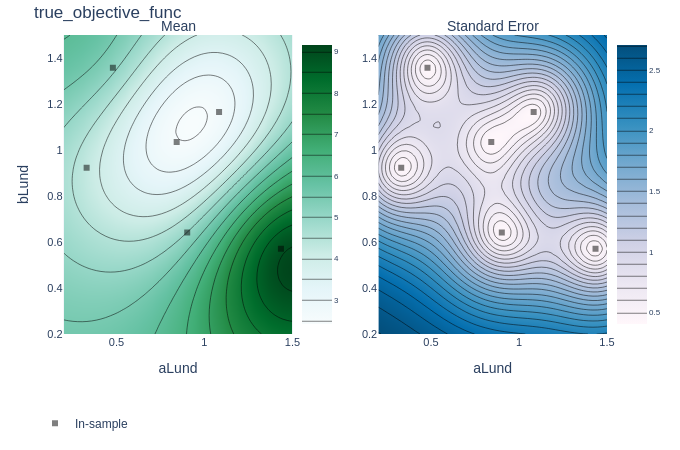

In [14]:
best_parameters, values = ax_client.get_best_parameters()

print("BEST PARAMETERS: ", best_parameters)

import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(
render(ax_client.get_contour_plot())
# )

# fig.show()
# fig.write_image("images/Lund_a_b_countour.pdf")

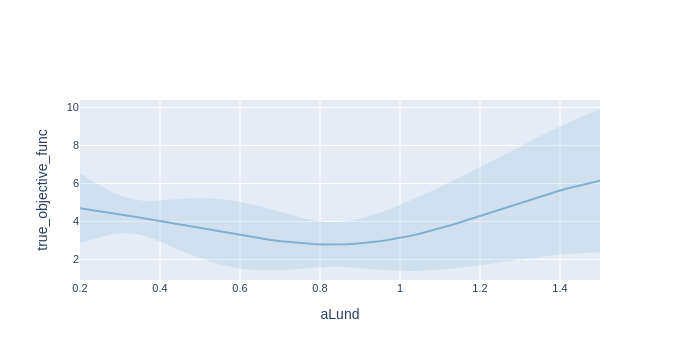

In [11]:
from ax.plot.slice import plot_slice

model = ax_client.generation_strategy.model
render(plot_slice(model, "aLund", "true_objective_func"))

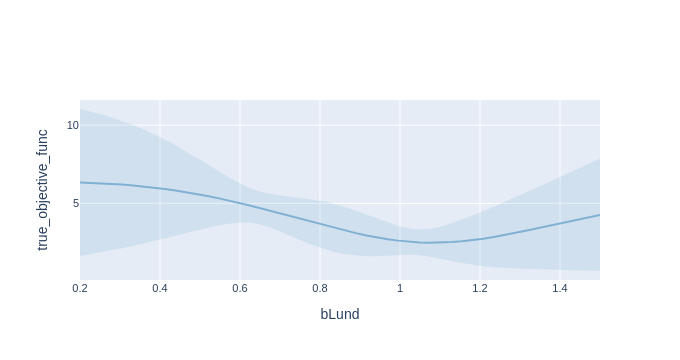

In [12]:
render(plot_slice(model, "bLund", "true_objective_func"))